# NNs in an FRTB Framework

## Notebook Setup


In [93]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.python.ops.numpy_ops import np_config
from itertools import product
np_config.enable_numpy_behavior()
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 100
from IPython.display import clear_output

from IPython.display import HTML
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os


In [94]:
!wget "https://www.1001fonts.com/download/latin-modern-roman.zip"
!mkdir Font
!unzip latin-modern-roman.zip -d Font

import matplotlib.font_manager as fm
import matplotlib

# fetch the name of font that was installed
path = "Font"
fontprop = fm.FontProperties(fname=path)

matplotlib.rcParams['font.family'] = fontprop.get_family()

clear_output()

In [95]:
# !rm -r {'PHD_Code'}
# !git clone https://github.com/Lolillosky/PHD_Code.git

import sys
sys.modules.pop
sys.path.insert(0,'PHD_Code/CODE')

clear_output()

In [96]:
tf.keras.backend.set_floatx('float64')

In [97]:
# PATH_DATA = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/DATA/"
# PATH_FIGS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/FIGS/"
# PATH_MODELS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/MODELS/"

PATH_DATA = "DATA/"
PATH_FIGS = "FIGS/"
PATH_MODELS = "MODELS/"
PATH_HTML = "HTML/"

In [98]:
import Enums
import Option_formulas
import Miscellanea
import Deep_learning_models
import ModelHandlers
import Scenario_Simulation

In [99]:
Option_formulas.BlackTF(1.0,1.0,1.0,0,0.2,True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07965565>

In [100]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load historical data and compute market schoks

In [101]:
hist_data = pd.read_excel(PATH_DATA + 'Hist_data.xlsx', index_col='Dates')
# print(len(hist_data))
hist_data = hist_data.drop_duplicates(keep='first')
# print(len(hist_data))
display(hist_data.head(3))
display(hist_data.tail(3))


Apple_Spot  Apple_Vol  IBM_Spot  IBM_Vol  JMP_Spot  JPM_Vol
Dates                                                                  
2010-01-01       7.526     37.458  125.0310   23.275     41.67   35.088
2010-01-04       7.643     37.428  126.5115   23.198     42.85   34.045
2010-01-05       7.656     38.004  124.9832   23.318     43.68   33.323

Apple_Spot  Apple_Vol  IBM_Spot  IBM_Vol  JMP_Spot  JPM_Vol
Dates                                                                  
2022-12-05      146.63     33.703    147.41   24.694    131.37   28.843
2022-12-06      142.91     34.215    147.50   24.998    131.59   29.305
2022-12-07      140.94     34.771    147.27   25.134    131.50   29.658

In [102]:
hist_data.to_excel('borra.xlsx')

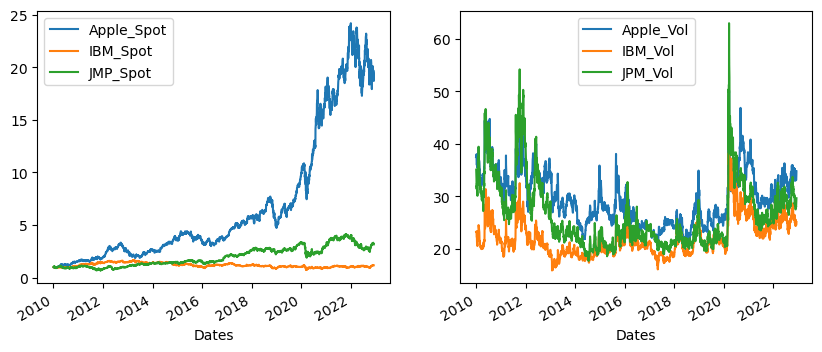

In [103]:
f, ax = plt.subplots(1,2, figsize=(10,4))

(hist_data/hist_data.iloc[0])[['Apple_Spot','IBM_Spot','JMP_Spot']].plot(ax = ax[0])

hist_data[['Apple_Vol', 'IBM_Vol', 'JPM_Vol']].plot(ax = ax[1])

plt.savefig(PATH_FIGS + 'Mkt_data.pdf')

### Computation of 1d and 10d schocks

In [104]:
risk_horizon = 10
hist_data_length = 250

hist_schocks_10d = pd.DataFrame(data = np.log(hist_data.iloc[risk_horizon:].values/ hist_data.iloc[0:-risk_horizon].values),
                            index =  hist_data.index[risk_horizon:], columns = hist_data.columns)

hist_schocks_10d = hist_schocks_10d.iloc[-hist_data_length:]

hist_schocks_1d = pd.DataFrame(data = np.log(hist_data.iloc[1:].values/ hist_data.iloc[0:-1].values),
                            index =  hist_data.index[1:], columns = hist_data.columns)

hist_schocks_1d = hist_schocks_1d.iloc[-hist_data_length:]


### Plot historical schocks. 1d / 10d

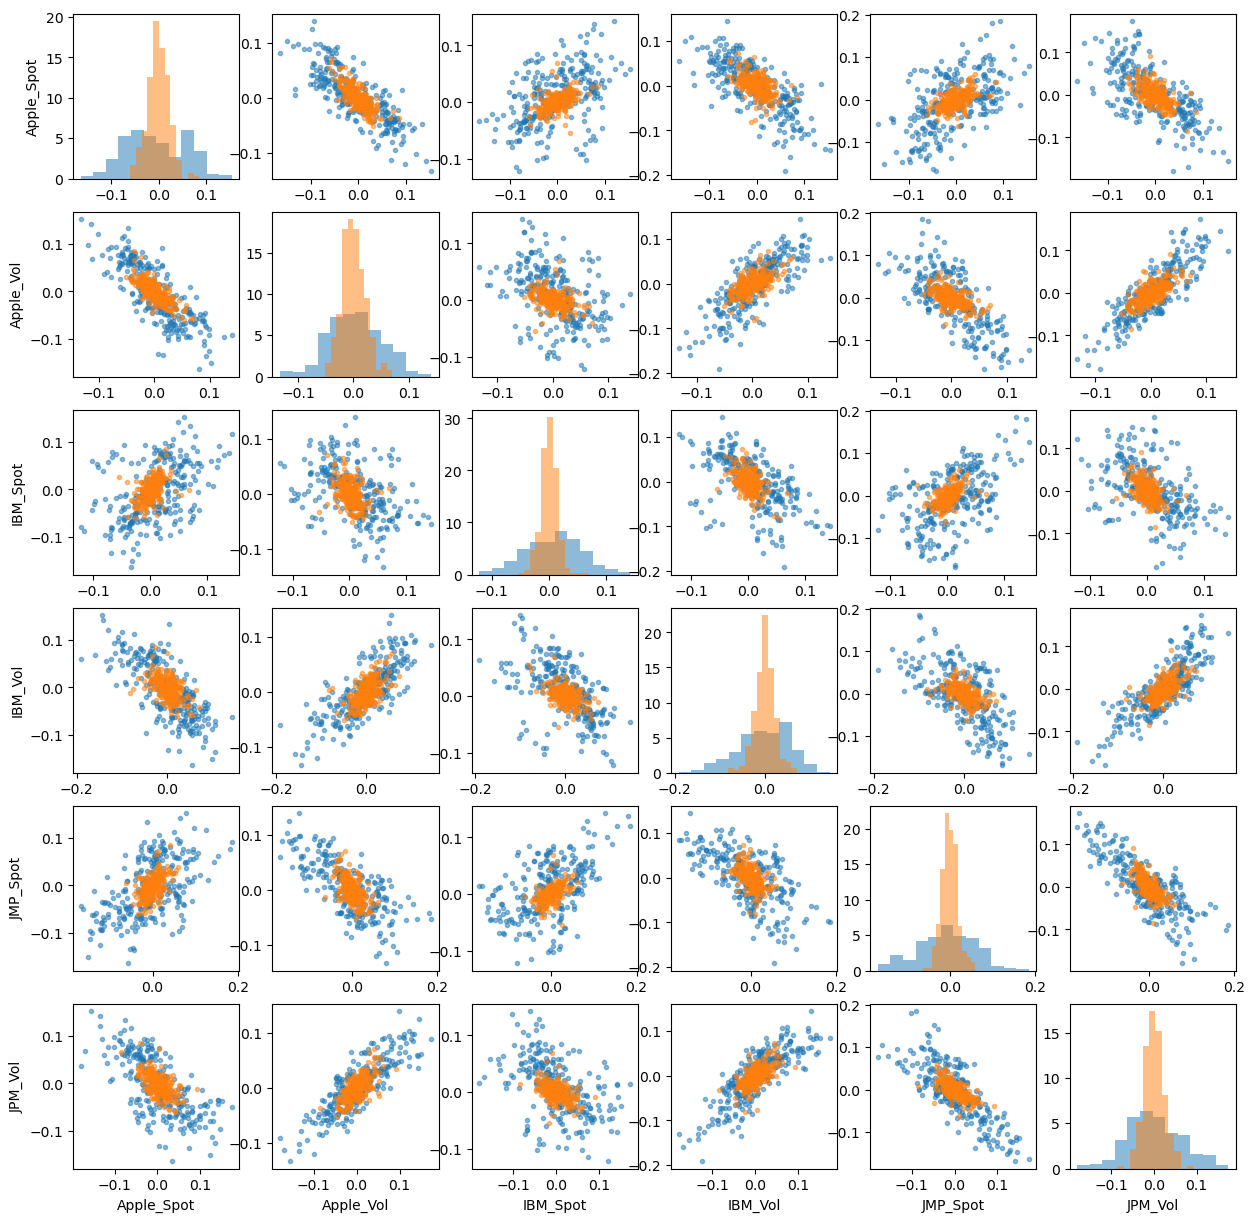

In [105]:
Miscellanea.plot_schocks(6,[hist_schocks_10d.values,hist_schocks_1d.values],hist_schocks_10d.columns,12)

plt.savefig(PATH_FIGS + 'histdata_1d_10d.pdf')

## Calibrate historical data with gaussian mixture and generate training data

In [106]:
num_sims_train = 2**16
num_sims_test = 2**14

gaussian_model_dict = {
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': [1.0, 1.0, 1.0],
    'vol_indexes': [1, 3, 5],
    'vols': [0.2, 0.3, 0.15],
    'correlations': [[1.0, 0.6, 0.4], [0.6, 1.0, 0.7], [0.4, 0.7, 1.0]],
    'rfr': 0.01,
    'divs': 0.0
}

simulation_dict = {
    'number_of_scenarios': num_sims_train + num_sims_test,
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.NO
}

indiv_strikes = [1.0, 1.0, 1.0]
option_strike = 1.0

contract_data_dict = {
    'ttm': 3.0,
    'payoff': lambda spot_t: Scenario_Simulation.basket_option(
        spot_t,
        indiv_strikes=indiv_strikes,
        option_strike=option_strike,
        tf_option=simulation_dict['tf_generation_option']
    )
}

dict_1d_results = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_1d.values)

gaussian_model_dict['gaussian_model_seed'] = 91011
simulation_dict['simulation_seed'] = 123321


dict_10d_results = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_10d.values)

train_data_keys = ['sim_scenario_levels', 'payoff', 'pathwise_derivs']

dict_1d_results_train = {k:dict_1d_results[k] for k in train_data_keys}
dict_10d_results_train = {k:dict_10d_results[k] for k in train_data_keys}


dict_mixed_data_train = Miscellanea.shuffle_arrays_in_dict(
    Miscellanea.concat_dict_containing_np_arrays([dict_1d_results_train,dict_10d_results_train]))

del dict_1d_results_train
del dict_10d_results_train



### Plot synthetic data + real data

#### 1 day shocks

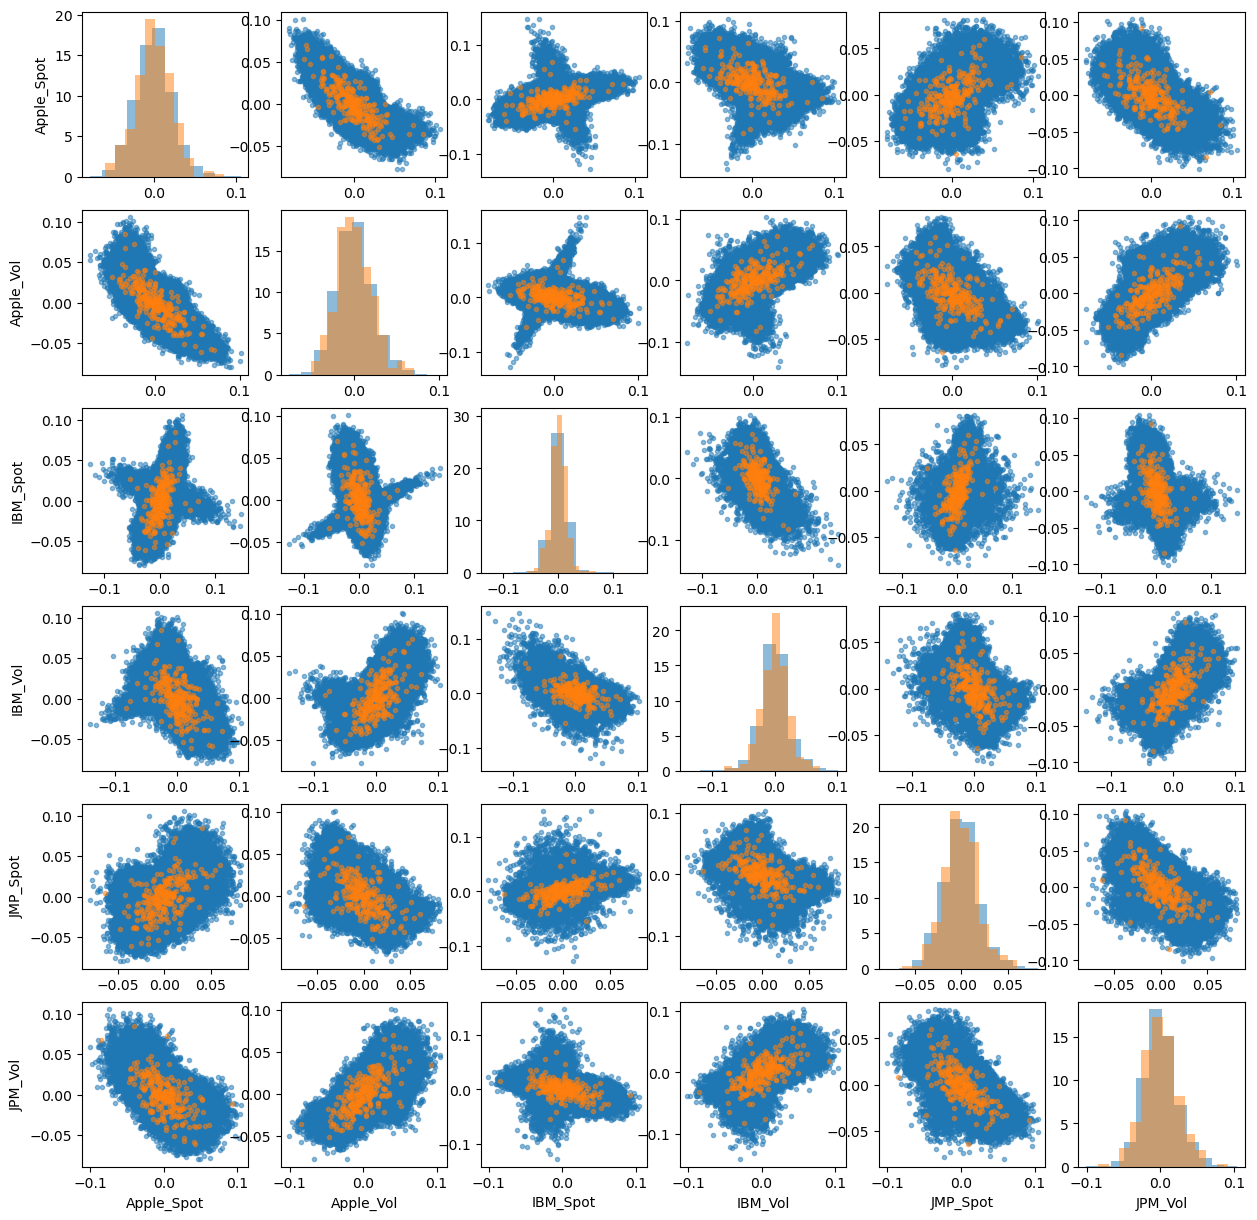

In [107]:
Miscellanea.plot_schocks(6,[dict_1d_results['sim_scenario_shifts'], hist_schocks_1d.values],hist_schocks_1d.columns,12)

#### 10 day schocks

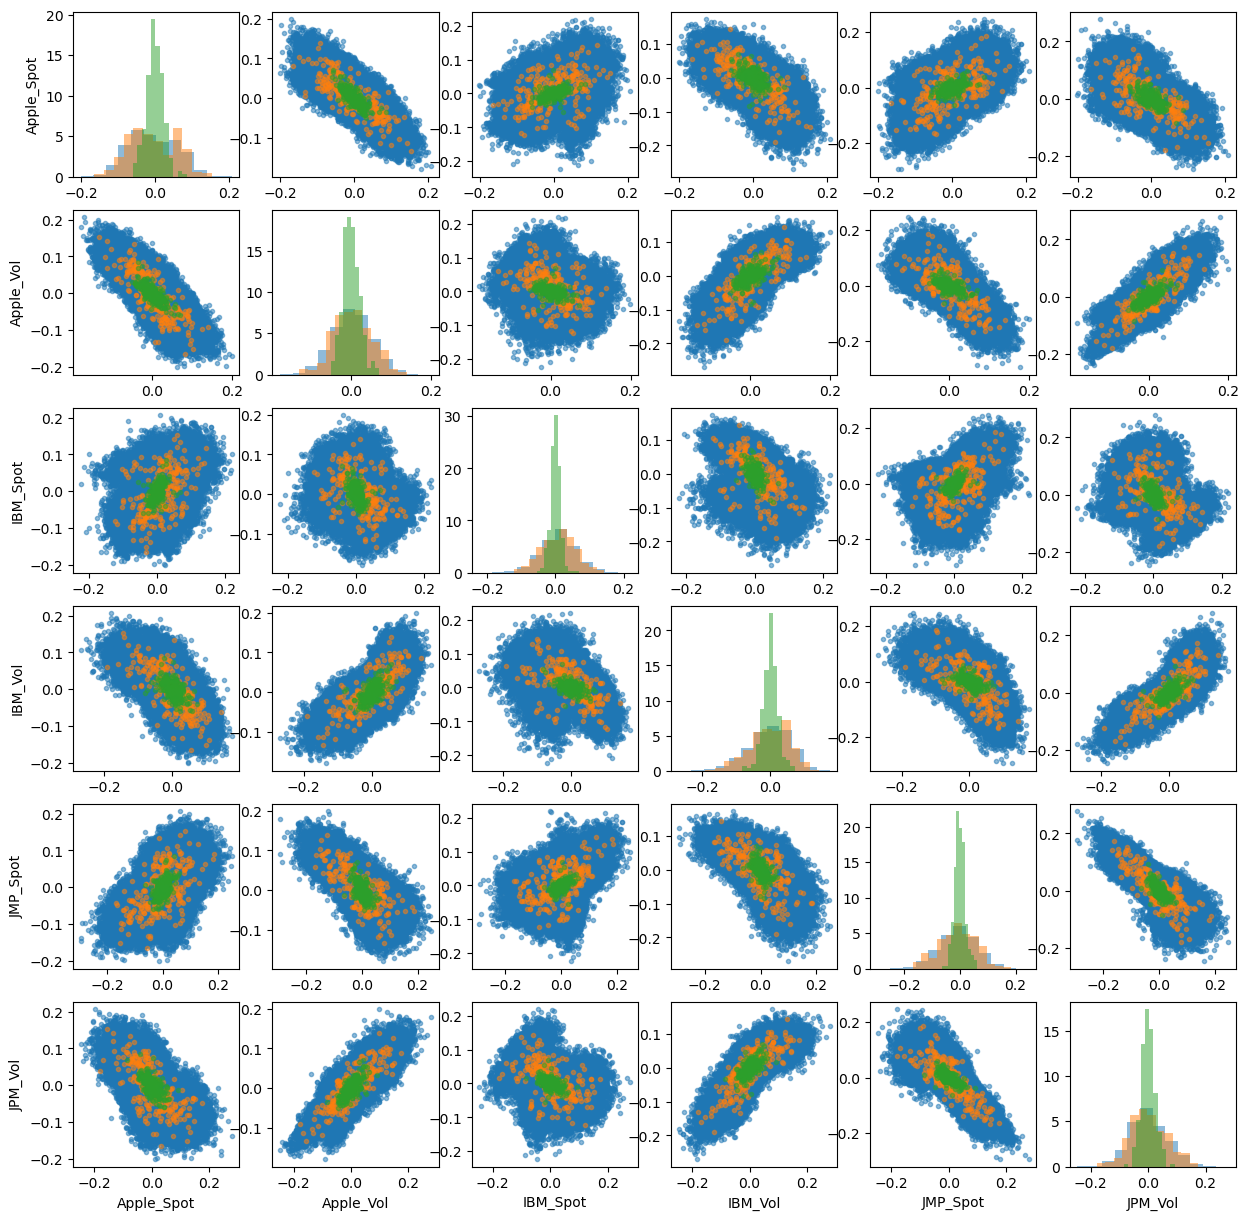

In [108]:
Miscellanea.plot_schocks(6,[dict_10d_results['sim_scenario_shifts'], hist_schocks_10d.values, hist_schocks_1d.values],hist_schocks_1d.columns,12)

### Compute closed form formulas for different scenarios (inc base with sensitivities)

In [109]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

base_scenario = dict_1d_results['base_scenario']


payoff_sim = dict_mixed_data_train['payoff']

closed_form_sim_scenario_levels = Option_formulas.BasketOptionVectorized(3,
                dict_mixed_data_train['sim_scenario_levels'][:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3),
                dict_mixed_data_train['sim_scenario_levels'][:,base_scenario_dict['vol_indexes']],
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy()

closed_form_hist_scenario_levels_1d = Option_formulas.BasketOptionVectorized(3,
                dict_1d_results['hist_scenario_levels'][:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3),
                dict_1d_results['hist_scenario_levels'][:,base_scenario_dict['vol_indexes']],
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy()

closed_form_hist_scenario_levels_10d = Option_formulas.BasketOptionVectorized(3,
                dict_10d_results['hist_scenario_levels'][:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3),
                dict_10d_results['hist_scenario_levels'][:,base_scenario_dict['vol_indexes']],
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy()


base_scenario_TF = tf.constant(dict_1d_results['base_scenario'])

with tf.GradientTape() as tape:

    tape.watch(base_scenario_TF)

    closed_form_base = Option_formulas.BasketOptionVectorized(3,
            base_scenario_TF.reshape(1,-1)[:,base_scenario_dict['spot_indexes']],
            indiv_strikes, option_strike, base_scenario_dict['rfr'] * np.ones(3),
            base_scenario_dict['rfr'], base_scenario_dict['divs'] * np.ones(3),
            base_scenario_TF.reshape(1,-1)[:,base_scenario_dict['vol_indexes']],
            np.array(base_scenario_dict['correlations']),
            contract_data_dict['ttm'] , True)

  
sens_base_scenario = tape.gradient(closed_form_base, base_scenario_TF).numpy()

closed_form_base = closed_form_base.numpy()[0]

## Hedge calculations

In [138]:
TTM_Hedge = 3.0


call_A = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][0]],
                                                        indiv_strikes[0] , TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'],
                                                        MktData[:,base_scenario_dict['vol_indexes'][0]], True)
Fut_A = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][0]], indiv_strikes[0],
                                                 TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'])

call_B = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][1]],
                                                        indiv_strikes[1] , TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'],
                                                        MktData[:,base_scenario_dict['vol_indexes'][1]], True)
Fut_B = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][1]], indiv_strikes[1],
                                                 TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'])

call_C = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,base_scenario_dict['spot_indexes'][2]],
                                                        indiv_strikes[2] , TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'],
                                                        MktData[:,base_scenario_dict['vol_indexes'][2]], True)
Fut_C = lambda MktData: Option_formulas.FutureTF(MktData[:,base_scenario_dict['spot_indexes'][2]], indiv_strikes[2],
                                                 TTM_Hedge, base_scenario_dict['rfr'],
                                                        base_scenario_dict['divs'])



exot = lambda MktData: Option_formulas.BasketOptionVectorized(3, MktData[:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                  base_scenario_dict['rfr']*np.ones(3), base_scenario_dict['rfr'],
                  base_scenario_dict['divs']*np.ones(3),
                  MktData[:,base_scenario_dict['vol_indexes']], base_scenario_dict['correlations'],
                  contract_data_dict['ttm'], True)

# hedge_elements = [Fut_A, call_A, Fut_B, call_B, Fut_C, call_C]

hedge_elements = [Fut_A, Fut_B, Fut_C]

hedge_elements = [Fut_A, Fut_B, Fut_C, call_A, call_B]


hedge = Option_formulas.Basket(hedge_elements, exot)

hedge.compute_hedge(base_scenario)


In [139]:
hedge_base = hedge.value_basket(base_scenario)

hedge_sim_data_PL_inc = hedge.value_basket(dict_mixed_data_train['sim_scenario_levels']) - hedge_base

hedge_1d_NPV = hedge.value_basket(dict_1d_results['hist_scenario_levels'])

hedge_1d_PL_inc = hedge_1d_NPV - hedge_base

hedge_10d_PL_inc = hedge.value_basket(dict_10d_results['hist_scenario_levels']) - hedge_base


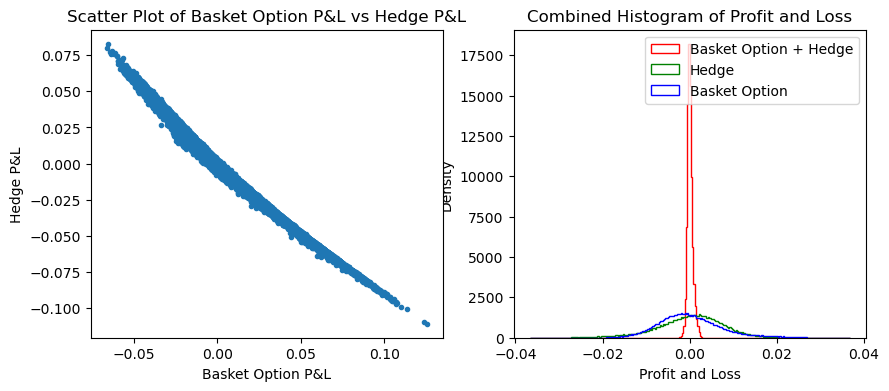

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming exot, my_basket, rf_levels_sim, and base_scenario are defined elsewhere in your code

bins = 250
# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# First subplot for the combined line histograms
plt.subplot(1, 2, 2)  # 2 rows, 1 column, first plot

# Combine the three histograms into a single plt.hist call with line style
plt.hist([exot(dict_1d_results['sim_scenario_levels']).numpy()-exot(base_scenario.reshape(1,-1)).numpy(),
          hedge.value_basket(dict_1d_results['sim_scenario_levels'])-hedge.value_basket(base_scenario),
          (exot(dict_1d_results['sim_scenario_levels']).numpy()-exot(base_scenario.reshape(1,-1)).numpy()) +
          (hedge.value_basket(dict_1d_results['sim_scenario_levels'])-hedge.value_basket(base_scenario))],
         bins=bins, histtype='step', label=['Basket Option', 'Hedge', 'Basket Option + Hedge'],
         color=['blue', 'green', 'red'])

plt.xlabel('Profit and Loss')
plt.ylabel('Density')
plt.title('Combined Histogram of Profit and Loss')
plt.legend()

# Second subplot for the scatter plot
plt.subplot(1, 2, 1)  # 2 rows, 1 column, second plot

plt.xlabel('Basket Option P&L')
plt.ylabel('Hedge P&L')
plt.title('Scatter Plot of Basket Option P&L vs Hedge P&L')

plt.plot(exot(dict_mixed_data_train['sim_scenario_levels']).numpy()-exot(base_scenario.reshape(1,-1)).numpy(),
         hedge.value_basket(dict_mixed_data_train['sim_scenario_levels'])-hedge.value_basket(base_scenario), '.')

# Save the figure
plt.savefig(PATH_FIGS + 'hedge_histogram_combined_lines.png')

plt.show()


## -----------------------------------NAIVE APPROACH-----------------------------------------------------

## <span style="color:red">-----------------Train Models (beware of the options)---------------.</span>

### Models fitted to 10d data

In [141]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]
# cells_layer = [64]
# num_hidden_layers = [3]
# num_hidden_layers = [1]

# PATH_MODELS = 'MODELS/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS/EARLY/'
PATH_MODELS = 'MODELS/MODELS_10D/'
# PATH_MODELS = 'MODELS/RED_SIMS_EARLY/'

batch_size = 32
valid_data = None
epochs = 20


ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_10d_results['sim_scenario_levels'][train_range],
              dict_10d_results['payoff'][train_range],
              dict_10d_results['pathwise_derivs'][train_range], epochs, batch_size, valid_data)


The folder 'MODELS/MODELS_10D/' exists. Do you want to delete its contents? (y/n)n
The contents of the folder 'MODELS/MODELS_10D/' were not deleted.
FITTING MODEL: alpha: 0, cells: 32, num_hidden: 1


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'MODELS/MODELS_10D/alpha_0_cells_32_hidden_1/'

### Models fitted to 1d data

In [142]:
PATH_MODELS = 'MODELS/MODELS_1D/'

batch_size = 32
valid_data = None
epochs = 20

ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_1d_results['sim_scenario_levels'][train_range],
              dict_1d_results['payoff'][train_range],
              dict_1d_results['pathwise_derivs'][train_range], epochs, batch_size, valid_data)

The folder 'MODELS/MODELS_1D/' exists. Do you want to delete its contents? (y/n)n
The contents of the folder 'MODELS/MODELS_1D/' were not deleted.
FITTING MODEL: alpha: 0, cells: 32, num_hidden: 1


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'MODELS/MODELS_1D/alpha_0_cells_32_hidden_1/'

### Models fitted to mixed data

In [ ]:
PATH_MODELS = 'MODELS/MODELS_MIXED2/'

train_range = np.arange(0,num_sims_train)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
num_hidden_layers = [1, 2, 3]

ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_mixed_data_train['sim_scenario_levels'][train_range],
              dict_mixed_data_train['payoff'][train_range],
              dict_mixed_data_train['pathwise_derivs'][train_range], epochs, batch_size, valid_data)

## <span style="color:red">-----------------End of model train---------------.</span>

### Load saved models

In [143]:
# PATH_MODELS = 'MODELS/MODELS_1D/'
# PATH_MODELS = 'MODELS/MODELS_10D/'
PATH_MODELS = 'MODELS/MODELS_MIXED/'


alphas = [0, 0.1, 0.5, 1.0, 10.0]
# cells_layer = [64]
# num_hidden_layers = [3]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

models = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)



### Compute bayes error

In [144]:
bayes_error_train = mean_squared_error(closed_form_sim_scenario_levels[train_range],
                                          payoff_sim[train_range])

bayes_error_cv = mean_squared_error(closed_form_sim_scenario_levels[test_range],
                                          payoff_sim[test_range])


print(bayes_error_train, bayes_error_cv)



0.04768484726457902 0.049115034152812195


### Compute metrics

In [145]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
#     adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS

else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]



metrics, best_model_metrics,best_model_zero_alpha_metrics = ModelHandlers.compute_model_metrics(
                    models, alphas, cells_layer, num_hidden_layers,
                    dict_mixed_data_train['sim_scenario_levels'][train_range], payoff_sim[train_range],
                    dict_mixed_data_train['sim_scenario_levels'][test_range],
                    payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario);




In [146]:
print(best_model_zero_alpha_metrics['model_params'])
print(best_model_zero_alpha_metrics['mse_cv'])
print(best_model_zero_alpha_metrics['ks_1d'])
print(best_model_zero_alpha_metrics['spearman_1d'])


{'alpha': 0, 'cells': 64, 'hidden': 2}
0.049144675712416194
0.036
0.9996121537944607


In [147]:
print(best_model_metrics['model_params'])
print(best_model_metrics['mse_cv'])
print(best_model_metrics['ks_1d'])
print(best_model_metrics['spearman_1d'])

{'alpha': 1.0, 'cells': 64, 'hidden': 3}
0.04910447668432102
0.016
0.9999731195699132


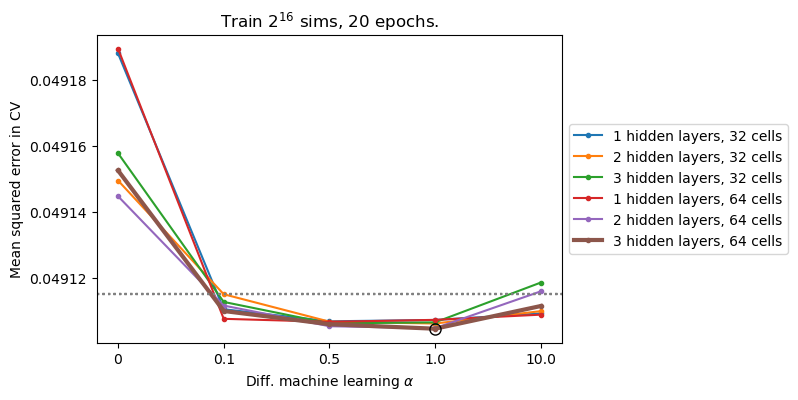

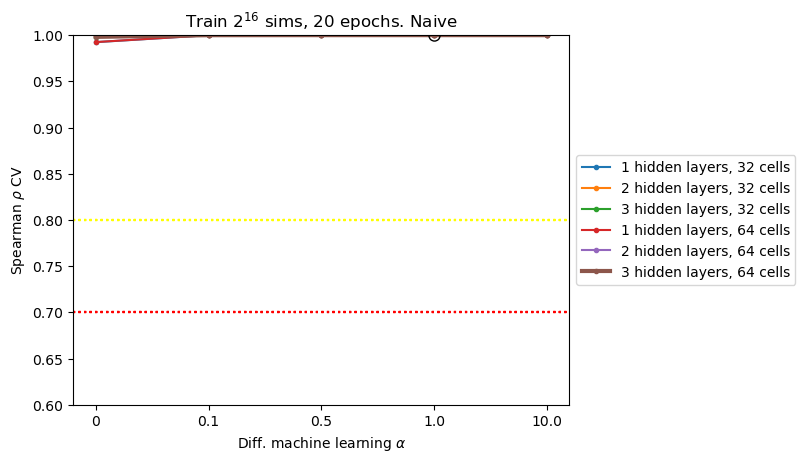

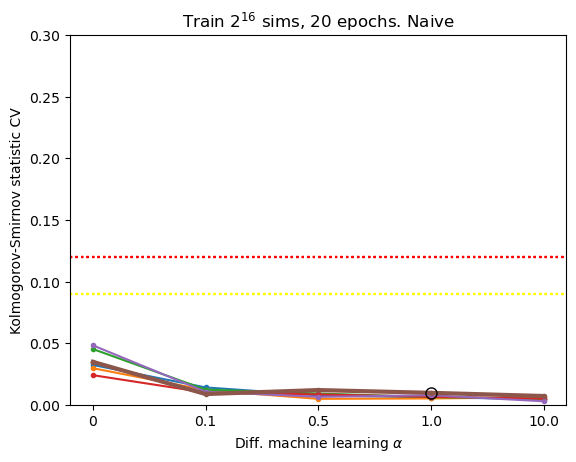

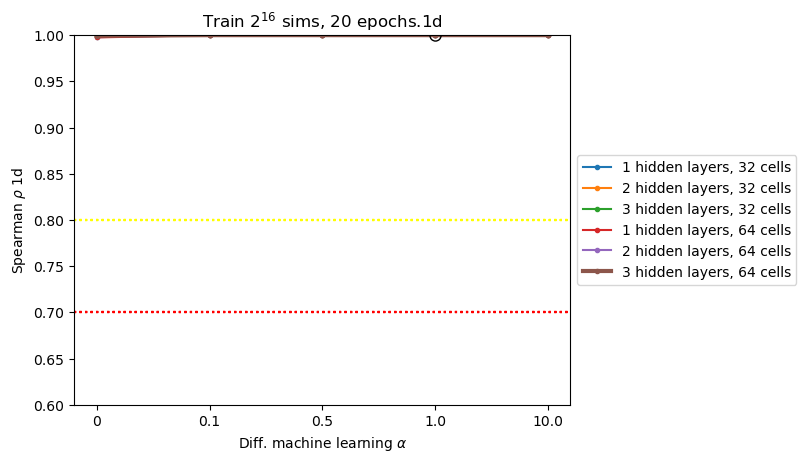

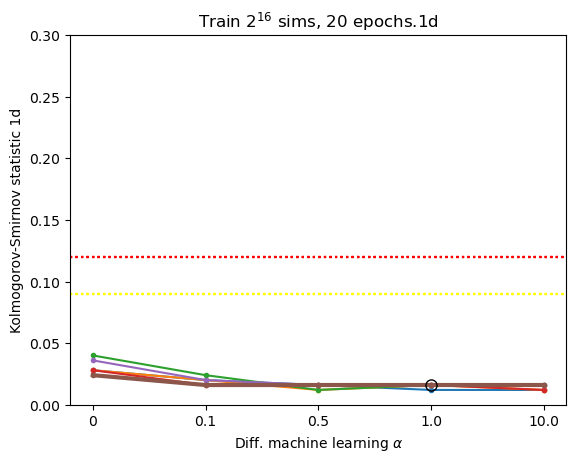

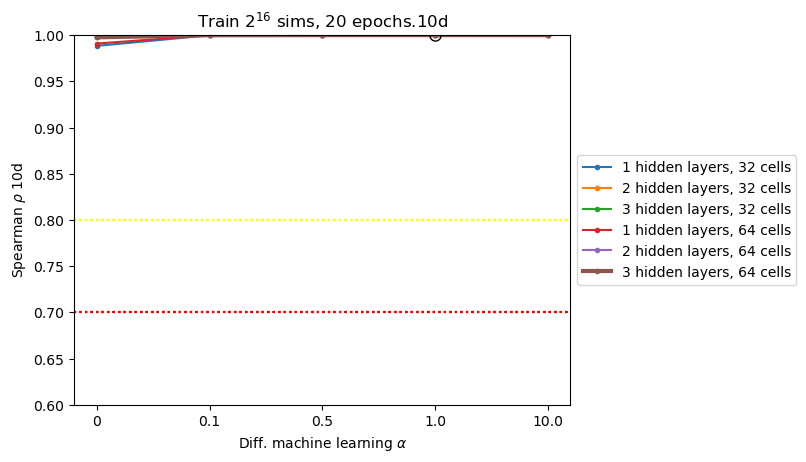

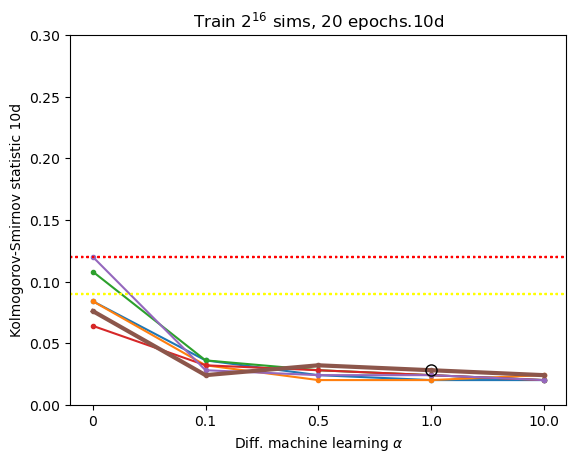

<Figure size 640x480 with 0 Axes>

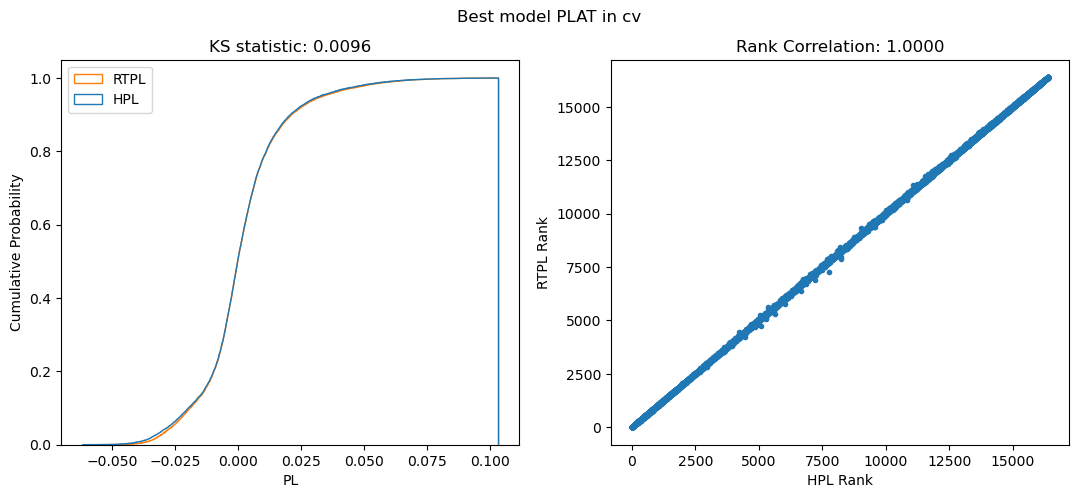

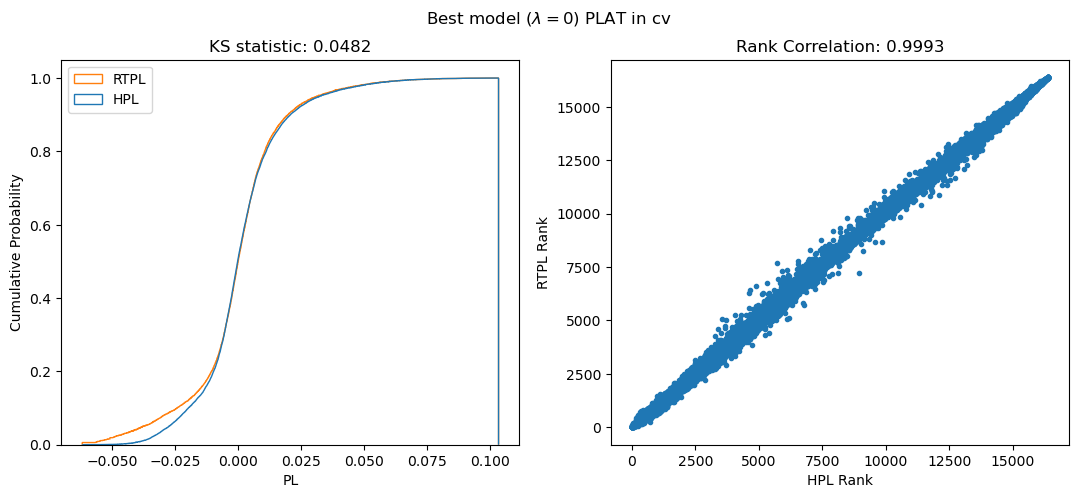

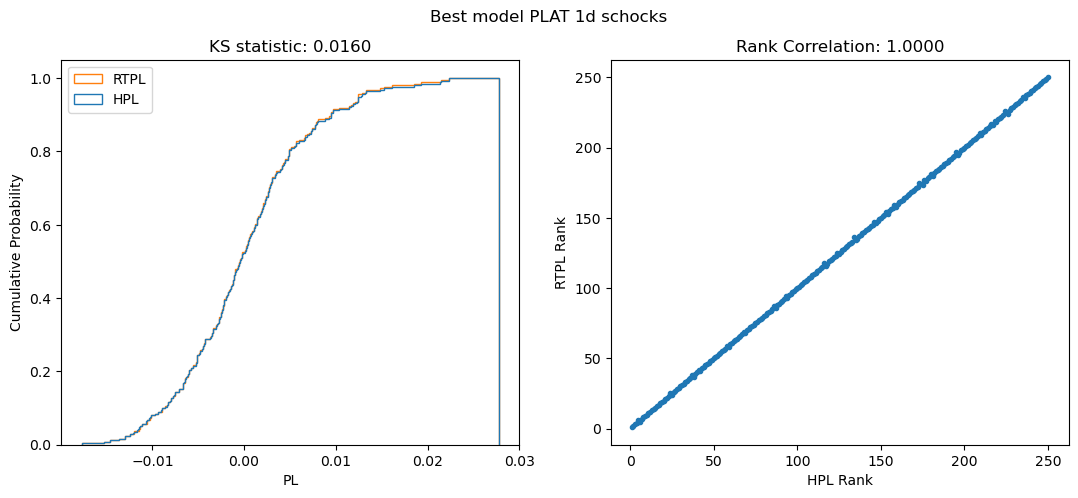

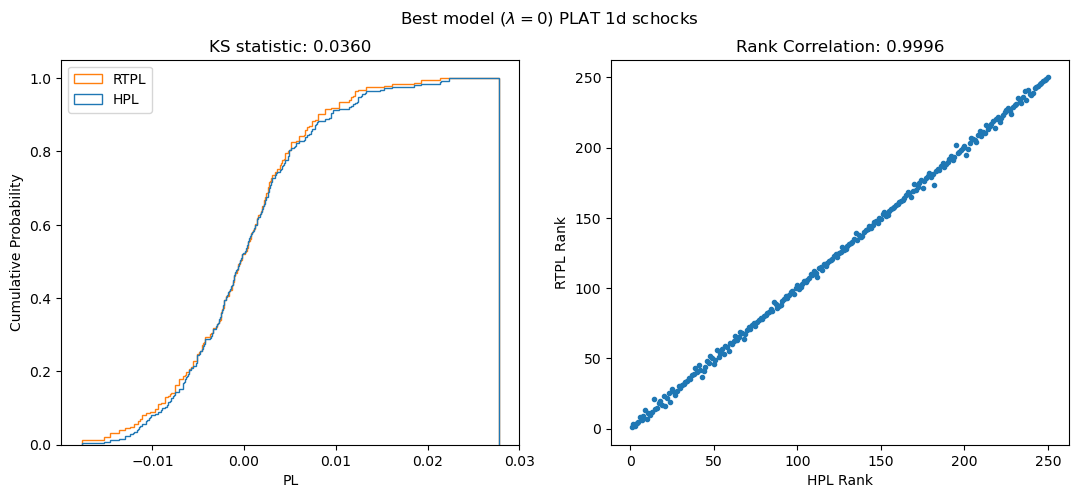

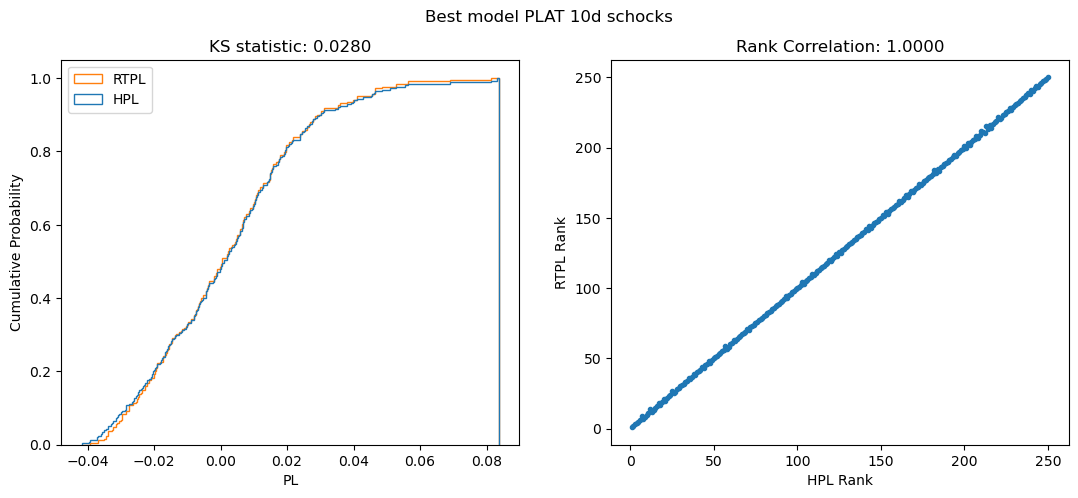

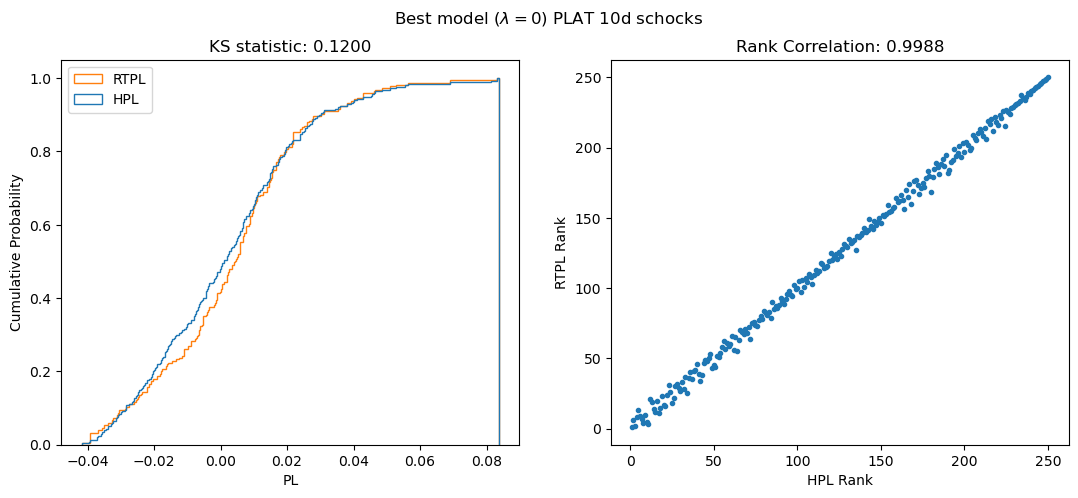

In [148]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:]

if PATH_MODELS == 'MODELS/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = '_NAIVE_'


file_name = "CV_" + file_name

ModelHandlers.plot_model_results(metrics, best_model_metrics,best_model_zero_alpha_metrics,alphas, cells_layer, num_hidden_layers, test_scenario_names,
                                 bayes_error_cv, file_name, chart_name, " Naive",PATH_FIGS)

### Compute metrics with hedge basket

In [149]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    hedge_sim_data_PL_inc

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
#     adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + hedge_1d_PL_inc,
                     'model_adj': model_adj_test + hedge_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + hedge_10d_PL_inc,
                     'model_adj': model_adj_test + hedge_10d_PL_inc}]

metrics, best_model_metrics,best_model_zero_alpha_metrics  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    dict_mixed_data_train['sim_scenario_levels'][train_range], payoff_sim[train_range], dict_mixed_data_train['sim_scenario_levels'][test_range], payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + hedge_sim_data_PL_inc[train_range],
                    model_adj_test + hedge_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)




In [150]:
print(best_model_zero_alpha_metrics['model_params'])
print(best_model_zero_alpha_metrics['mse_cv'])
print(best_model_zero_alpha_metrics['ks_1d'])
print(best_model_zero_alpha_metrics['spearman_1d'])

{'alpha': 0, 'cells': 64, 'hidden': 2}
0.049144675712416194
0.24
0.5621992031872509


In [151]:
print(best_model_metrics['model_params'])
print(best_model_metrics['mse_cv'])
print(best_model_metrics['ks_1d'])
print(best_model_metrics['spearman_1d'])

{'alpha': 1.0, 'cells': 64, 'hidden': 3}
0.04910447668432102
0.084
0.980328133250132


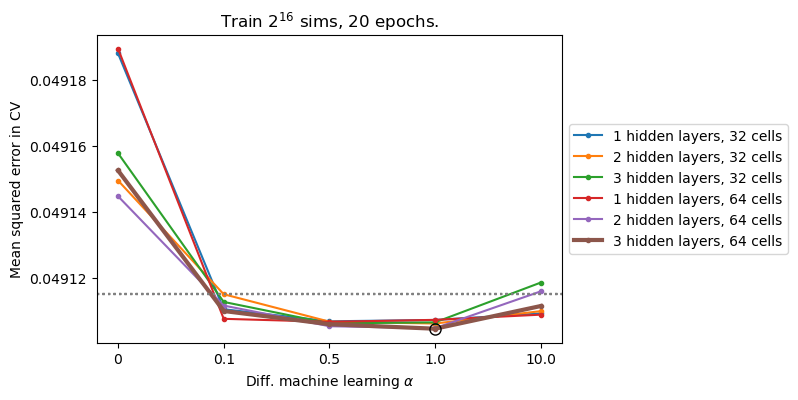

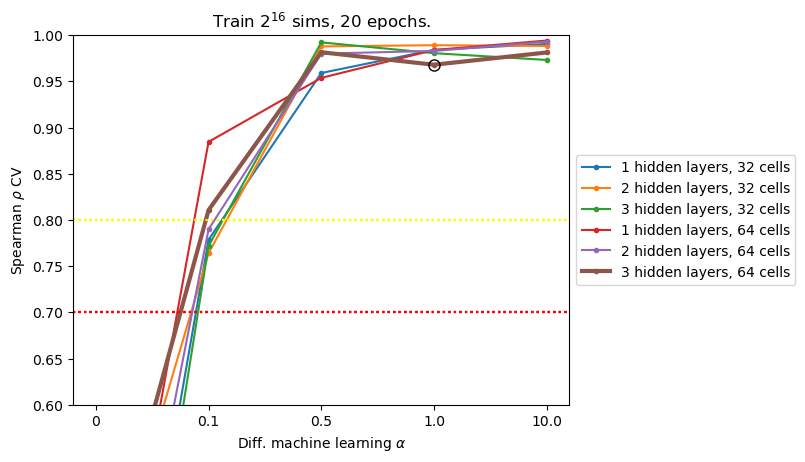

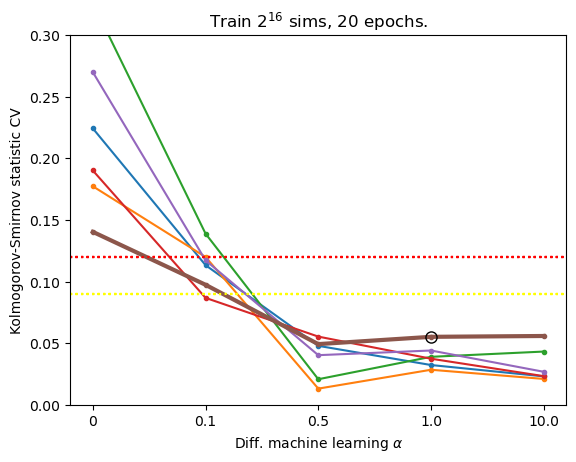

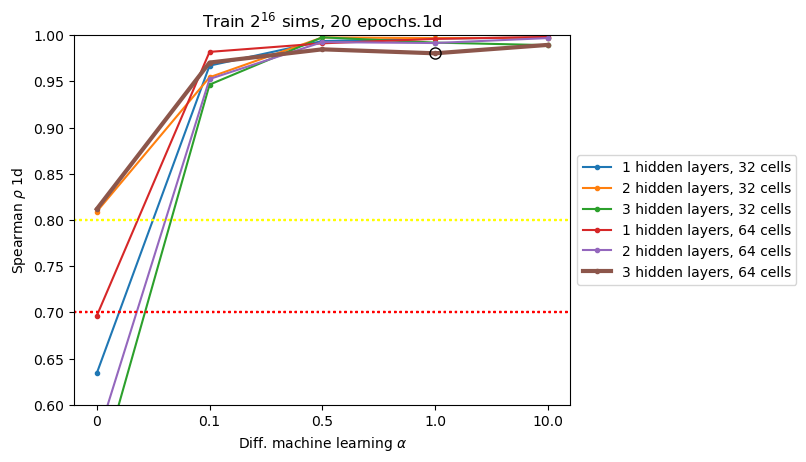

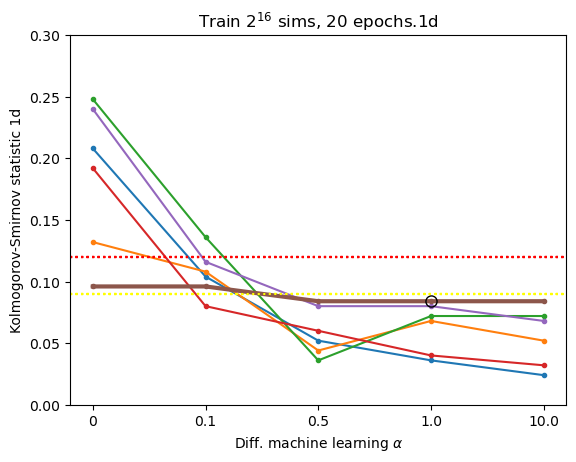

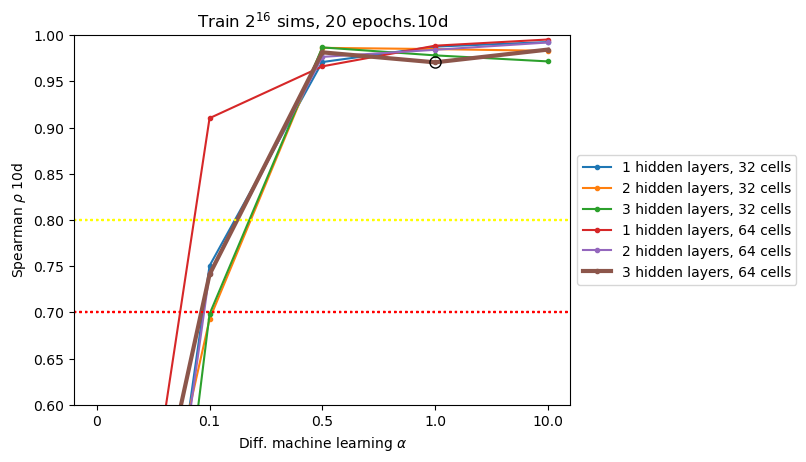

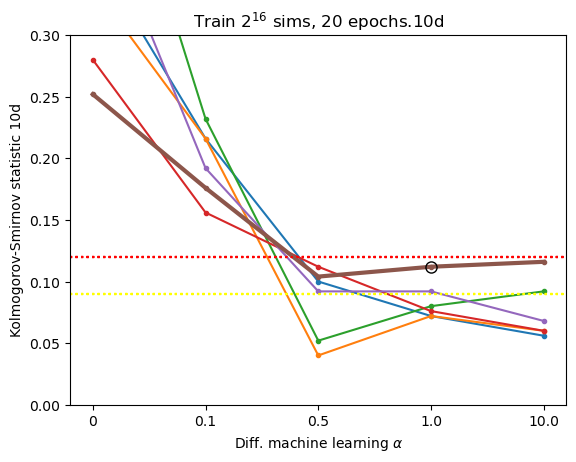

<Figure size 640x480 with 0 Axes>

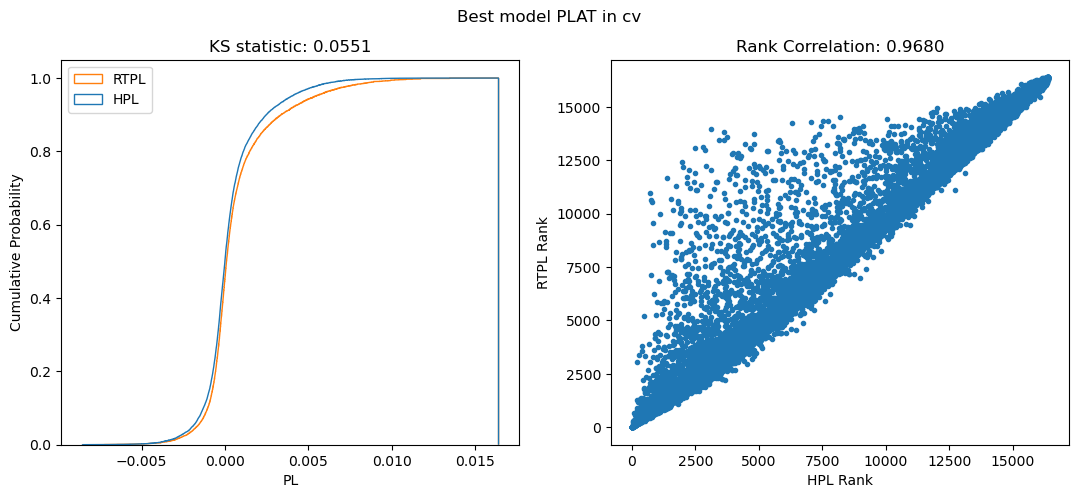

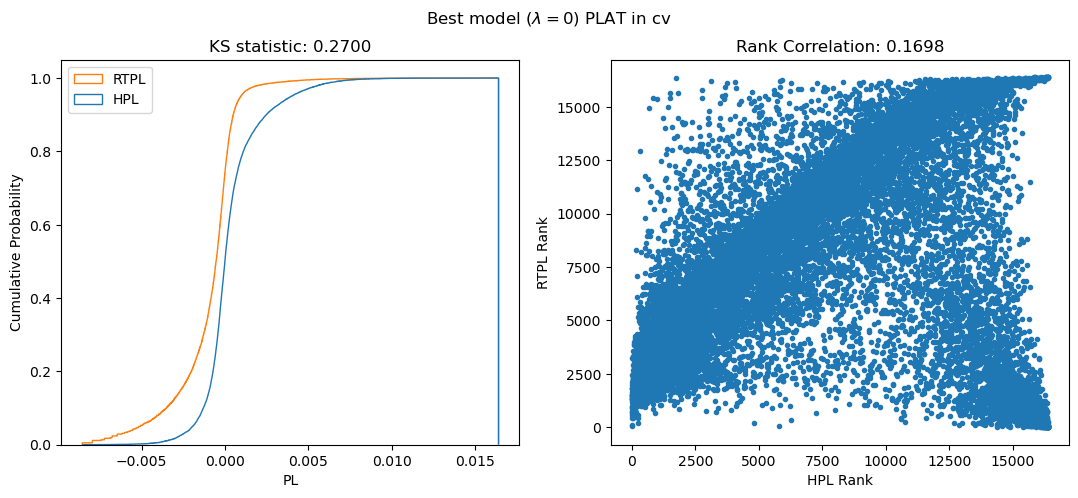

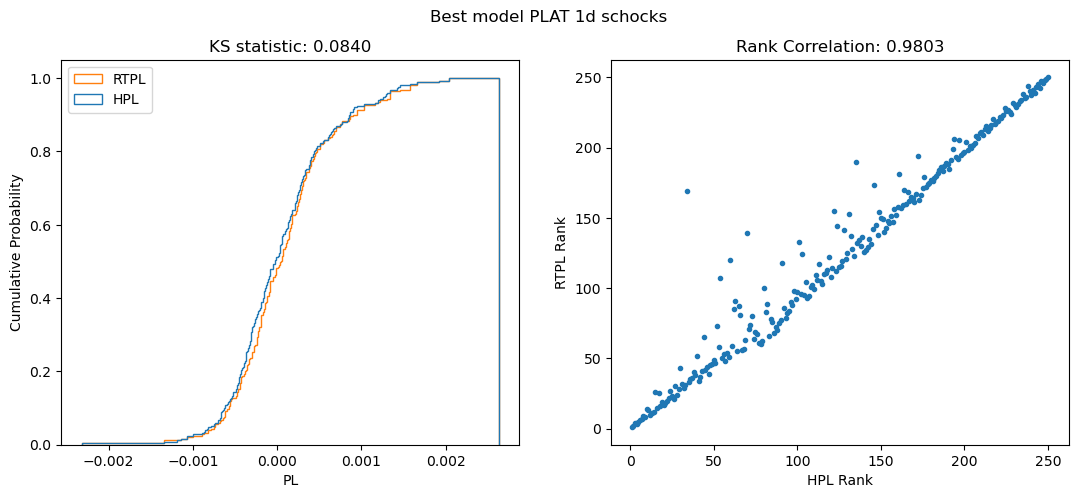

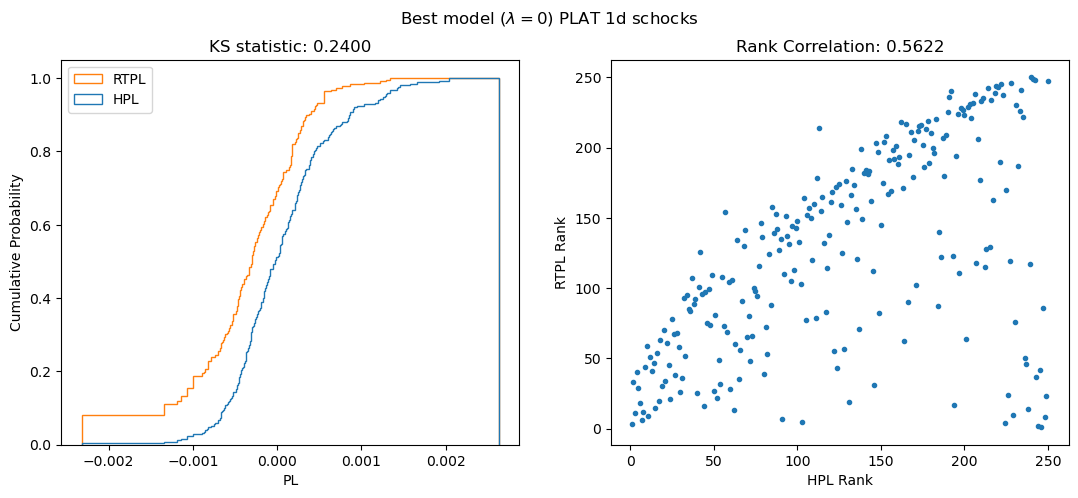

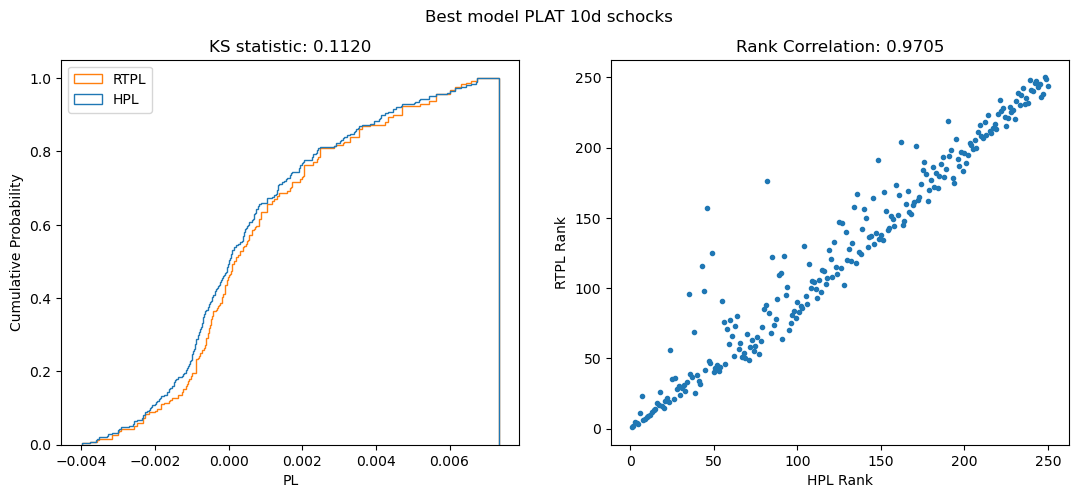

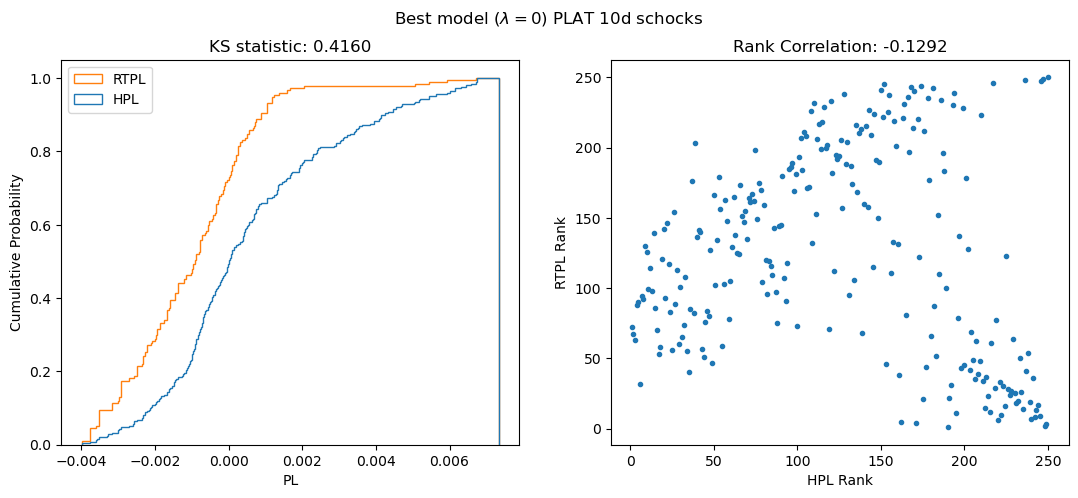

In [152]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:]

if PATH_MODELS == 'MODELS/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = '_NAIVE_'

file_name = 'Hedge_' + file_name

ModelHandlers.plot_model_results(metrics, best_model_metrics, best_model_zero_alpha_metrics, alphas,
                                 cells_layer, num_hidden_layers, test_scenario_names,
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

### Evolution of PLAT as model is trained

In [153]:
tf.keras.utils.set_random_seed(9876)


base_scenario_data = {'scenario_levels': dict_1d_results['base_scenario'].reshape(1,-1),
                      'closed_form_value': closed_form_base,
                      'closed_form_sens': sens_base_scenario,
                      'hedge_NPV': hedge_base}

test_scenario_data = { 'scenario_name': '1d',
                        'scenario_levels': dict_1d_results['hist_scenario_levels'],
                        'closed_form_value': closed_form_hist_scenario_levels_1d,
                        'hedge_NPV': hedge_1d_NPV}

train_scenario_data = {'scenario_levels': dict_mixed_data_train['sim_scenario_levels'][train_range],
                        'payoff': dict_mixed_data_train['payoff'][train_range],
                        'pathwise_derivs': dict_mixed_data_train['pathwise_derivs'][train_range]}

model_data =  {'input_dim': 6,
                'num_hidden_layers': 2,
                'num_cells_hidden_layers': 32,
                'hidden_layer_activation': 'softplus',
                'output_layer_activation': 'linear',
                'alpha': 0.0,
                'batch_size': 32,
                'num_epochs': 10,
                'verbose': 1}

plat_data = {'plat_analysis_option': Enums.Plat_Analysis_Option.NAIVE,
            'num_batches_callback': 256}

plat_results_trad_dict = ModelHandlers.PLAT_Analysis(base_scenario_data, test_scenario_data,
                            train_scenario_data, model_data, plat_data)

clear_output()

In [155]:
plat_results_trad_dict

{'plat_callback_NO': <Deep_learning_models.Plat_Callback at 0x22c75947b08>,
 'plat_callback_NPV': <Deep_learning_models.Plat_Callback at 0x22c759474c8>,
 'plat_callback_SENS': <Deep_learning_models.Plat_Callback at 0x22c75947488>,
 'plat_callback_Hedge_NO': <Deep_learning_models.Plat_Callback at 0x22c1c1c8748>,
 'plat_callback_Hedge_NPV': <Deep_learning_models.Plat_Callback at 0x22c72d1fa88>,
 'plat_callback_Hedge_SENS': <Deep_learning_models.Plat_Callback at 0x22c72d1f488>}

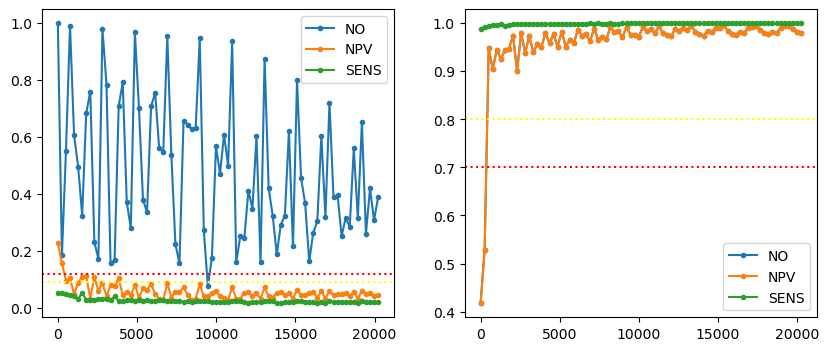

In [156]:
Miscellanea.plot_plat_training([plat_results_trad_dict['plat_callback_NO'],
                    plat_results_trad_dict['plat_callback_NPV'],plat_results_trad_dict['plat_callback_SENS']], 
                    ['NO', 'NPV', 'SENS'])

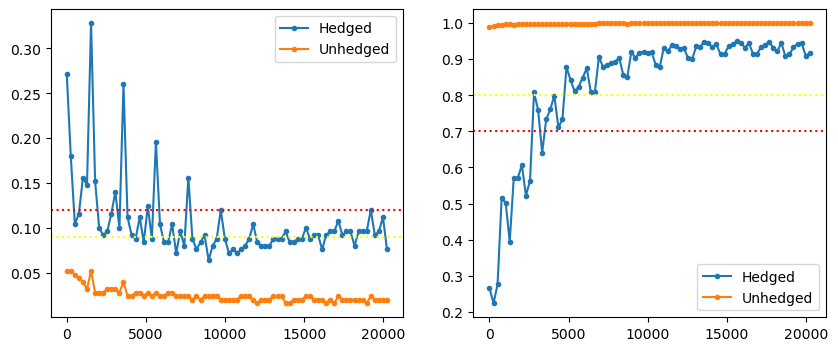

In [157]:
Miscellanea.plot_plat_training([plat_results_trad_dict['plat_callback_Hedge_SENS'],
                    plat_results_trad_dict['plat_callback_SENS']], ['Hedged', 'Unhedged'])

In [158]:
model_data =  {'input_dim': 6,
                'num_hidden_layers': 3,
                'num_cells_hidden_layers': 64,
                'hidden_layer_activation': 'softplus',
                'output_layer_activation': 'linear',
                'alpha': 1.0,
                'batch_size': 32,
                'num_epochs': 10,
                'verbose': 1}

plat_results_diff_learn_dict = ModelHandlers.PLAT_Analysis(base_scenario_data, test_scenario_data,
                            train_scenario_data, model_data, plat_data)

clear_output()

In [131]:
Miscellanea.plot_plat_training_plotly(
                    [plat_results_trad_dict['plat_callback_Hedge_SENS'],
                    plat_results_trad_dict['plat_callback_SENS'],
                    plat_results_diff_learn_dict['plat_callback_Hedge_SENS'],
                    plat_results_diff_learn_dict['plat_callback_SENS']],
                    ['Hedged', 'Unhedged', 'Hedged Diff Learning', 'Unhedged  Diff Learning'],
                    PATH_HTML + 'training_naive.html', PATH_FIGS + 'training_naive.pdf')

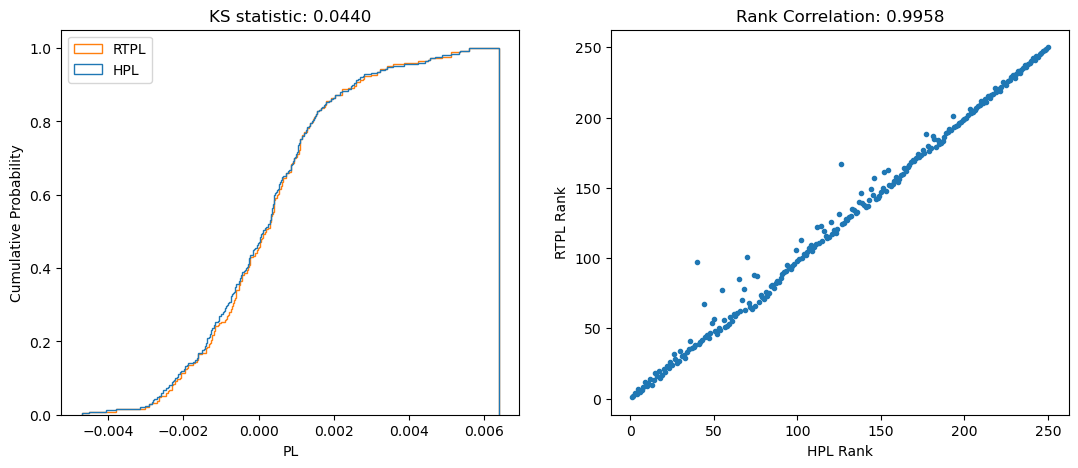

In [129]:
Miscellanea.plot_plat_charts(plat_results_diff_learn_dict['plat_callback_Hedge_SENS'].output_dict['y_true'][-1],
                             plat_results_diff_learn_dict['plat_callback_Hedge_SENS'].output_dict['y_pred'][-1]);

plt.savefig(PATH_FIGS + 'Plat_chart.pdf')

In [ ]:
html_output = Miscellanea.animate_plat_evolution(plat_results_diff_learn_dict['plat_callback_NO'],
            "Naive approach. Unhedged basket option. " + r"$\lambda=1.0$" + "   ",
                                                PATH_HTML + 'Naive_Unhedged_animation.html')

HTML(html_output)


In [ ]:
Miscellanea.plot_plat_training_plotly(
                    [plat_results_trad_dict['plat_callback_Hedge_NPV'],
                    plat_results_trad_dict['plat_callback_NPV'],
                    plat_results_diff_learn_dict['plat_callback_Hedge_NPV'],
                    plat_results_diff_learn_dict['plat_callback_NPV']],
                    ['Hedged', 'Unhedged', 'Hedged Diff Learning', 'Unhedged  Diff Learning'],
                    PATH_HTML + 'training_npv.html', PATH_FIGS + 'training_npv.pdf')

In [ ]:
html_output = Miscellanea.animate_plat_evolution(plat_results_trad_dict['plat_callback_Hedge_NPV'],
            "NPV control variable approach. Hedged basket option. " + r"$\lambda=0.0$" + "   ",
                                                PATH_HTML + 'NPV_Hedged_animation_trad.html')

HTML(html_output)


In [ ]:
Miscellanea.plot_plat_charts(plat_results_trad_dict['plat_callback_Hedge_NPV'].output_dict['y_true'][-1],
                             plat_results_trad_dict['plat_callback_Hedge_NPV'].output_dict['y_pred'][-1]);

plt.savefig(PATH_FIGS + 'Plat_chart_Hedged_NPV_trad.pdf')

In [ ]:
Miscellanea.plot_plat_training_plotly(
                    [plat_results_trad_dict['plat_callback_Hedge_SENS'],
                    plat_results_trad_dict['plat_callback_SENS'],
                    plat_results_diff_learn_dict['plat_callback_Hedge_SENS'],
                    plat_results_diff_learn_dict['plat_callback_SENS']],
                    ['Hedged', 'Unhedged', 'Hedged Diff Learning', 'Unhedged  Diff Learning'],
                    PATH_HTML + 'training_sens.html', PATH_FIGS + 'training_sens.pdf')

In [ ]:
Miscellanea.plot_plat_charts(plat_results_trad_dict['plat_callback_Hedge_SENS'].output_dict['y_true'][-1],
                             plat_results_trad_dict['plat_callback_Hedge_SENS'].output_dict['y_pred'][-1]);

plt.savefig(PATH_FIGS + 'Plat_chart_Hedged_Sens_trad.pdf')

In [ ]:
html_output = Miscellanea.animate_plat_evolution(plat_results_trad_dict['plat_callback_Hedge_SENS'],
            "NPV and sens control variable approach. Hedged basket option. " + r"$\lambda=0.0$" + "   ",
                                                PATH_HTML + 'Sens_Hedged_trad_animation.html')

HTML(html_output)


### Simulation of scenarios computing variance reduction

In [132]:
simulation_dict['Simulate_Var_Red_Payoff'] = Enums.Simulate_Var_Red_Payoff.YES


gaussian_model_dict['gaussian_model_seed'] = 1234
simulation_dict['simulation_seed'] = 5678

dict_1d_results_VR = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_1d.   values)



gaussian_model_dict['gaussian_model_seed'] = 91011
simulation_dict['simulation_seed'] = 123321



dict_10d_results_VR = Scenario_Simulation.calibrate_hist_data_simulate_training_data(
        gaussian_model_dict= gaussian_model_dict, base_scenario_dict= base_scenario_dict,
        simulation_dict= simulation_dict, contract_data_dict= contract_data_dict,
        hist_schocks_data= hist_schocks_10d.values)

dict_1d_results_train = {k:dict_1d_results_VR[k] for k in train_data_keys}
dict_10d_results_train = {k:dict_10d_results_VR[k] for k in train_data_keys}


dict_mixed_data_train_VR = Miscellanea.shuffle_arrays_in_dict(
    Miscellanea.concat_dict_containing_np_arrays([dict_1d_results_train,dict_10d_results_train]))

del dict_1d_results_train
del dict_10d_results_train





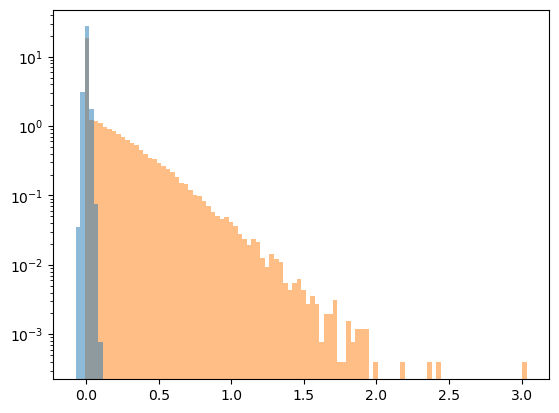

In [133]:


plt.hist([dict_1d_results_VR['payoff'], dict_1d_results['payoff']],
    bins = 100,density = True, stacked = False, histtype = 'stepfilled', alpha = 0.5);

plt.yscale('log');


### <span style="color:red">-----------------Train Models VR (beware of the options)---------------.</span>

## Models fitted to mixed data

In [ ]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]
# cells_layer = [64]
# num_hidden_layers = [3]
# num_hidden_layers = [1]


PATH_MODELS = 'MODELS_VR/MODELS_MIXED/'


batch_size = 32
valid_data = None
epochs = 20


ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_mixed_data_train_VR['sim_scenario_levels'][train_range],
              dict_mixed_data_train_VR['payoff'][train_range],
              dict_mixed_data_train_VR['pathwise_derivs'][train_range], epochs, batch_size, valid_data)


## <span style="color:red">-----------------End of model train---------------.</span>

### Load models data for variance reduction

In [85]:
# PATH_MODELS = 'MODELS_VR/MODELS_1D/'
# PATH_MODELS = 'MODELS_VR/MODELS_10D/'
PATH_MODELS = 'MODELS_VR/MODELS_MIXED/'

alphas = [0, 0.1, 0.5, 1.0, 10.0]
# cells_layer = [64]
# num_hidden_layers = [3]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

models = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)


if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    rf_levels_sim = dict_1d_results['sim_scenario_levels']
    payoff_sim = dict_1d_results['payoff']
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    rf_levels_sim = dict_10d_results['sim_scenario_levels']
    payoff_sim = dict_10d_results['payoff']
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    rf_levels_sim = dict_mixed_data_train['sim_scenario_levels']
    payoff_sim = dict_mixed_data_train['payoff']

closed_form_sim_scenario_levels = Option_formulas.BasketOptionVectorized(3,
                rf_levels_sim[:,base_scenario_dict['spot_indexes']],
                indiv_strikes, option_strike,
                base_scenario_dict['rfr'] * np.ones(3), base_scenario_dict['rfr'],
                base_scenario_dict['divs'] * np.ones(3),
                rf_levels_sim[:,base_scenario_dict['vol_indexes']],
                np.array(base_scenario_dict['correlations']),
                contract_data_dict['ttm'] , True).numpy()

### Compute metrics (no hedge)

In [86]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
#     adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - 0
    model_adj_cv = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base,
                   'model_adj': model_adj_test}]


metrics, best_model_metrics, best_model_zero_alpha_metrics = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    rf_levels_sim[train_range], payoff_sim[train_range],
                    rf_levels_sim[test_range],
                    payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train, model_adj_test,
                    test_scenarios_data, adjust_model_with_base_scenario)



# Plot charts (no hedge)

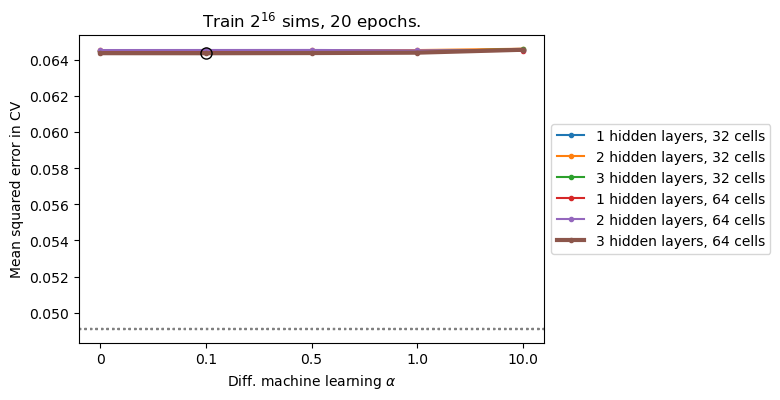

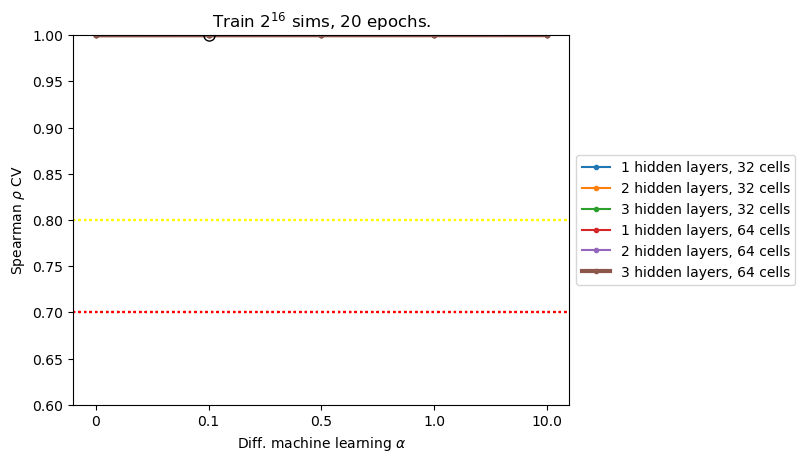

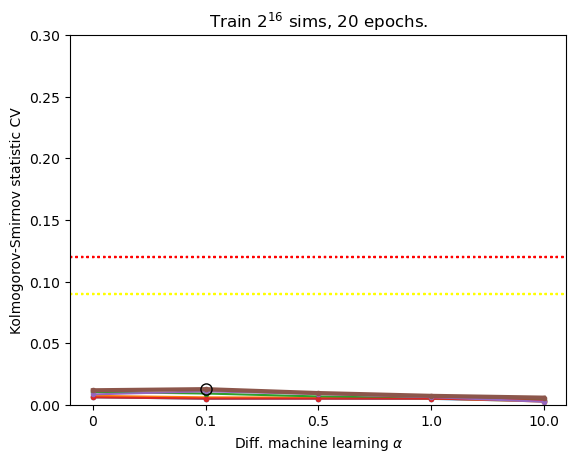

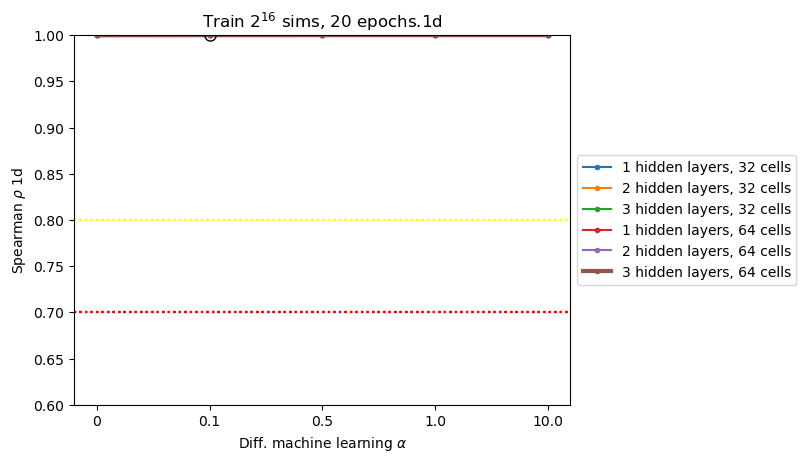

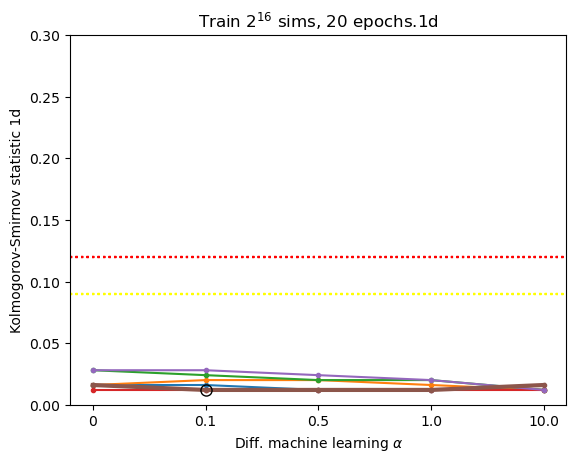

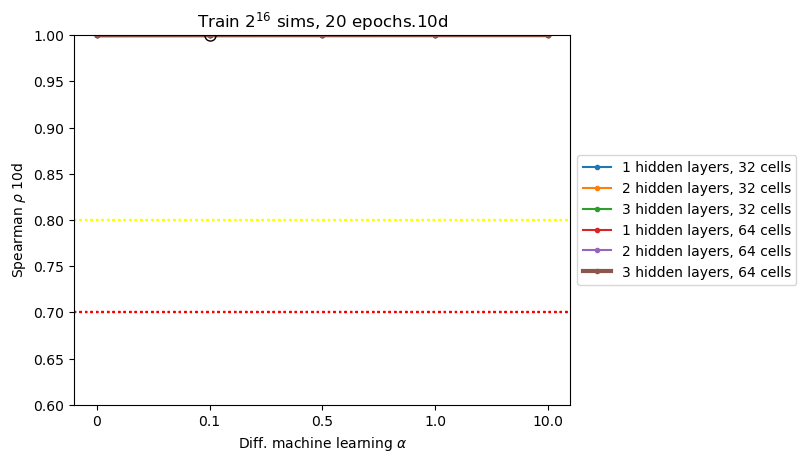

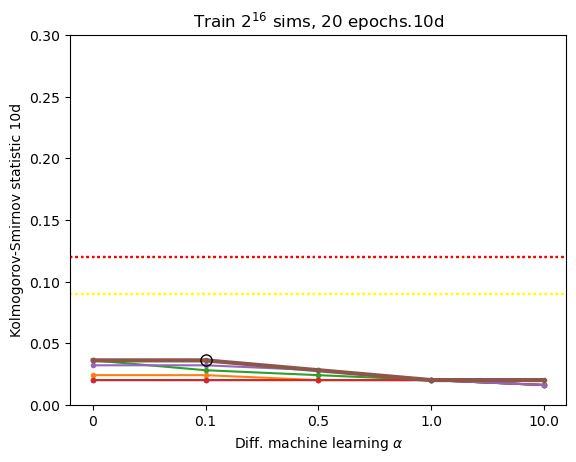

<Figure size 640x480 with 0 Axes>

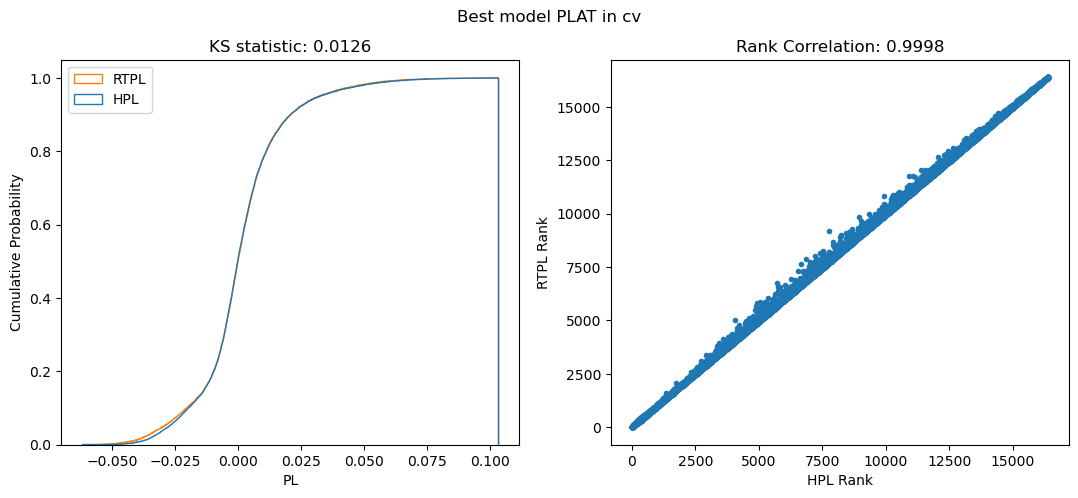

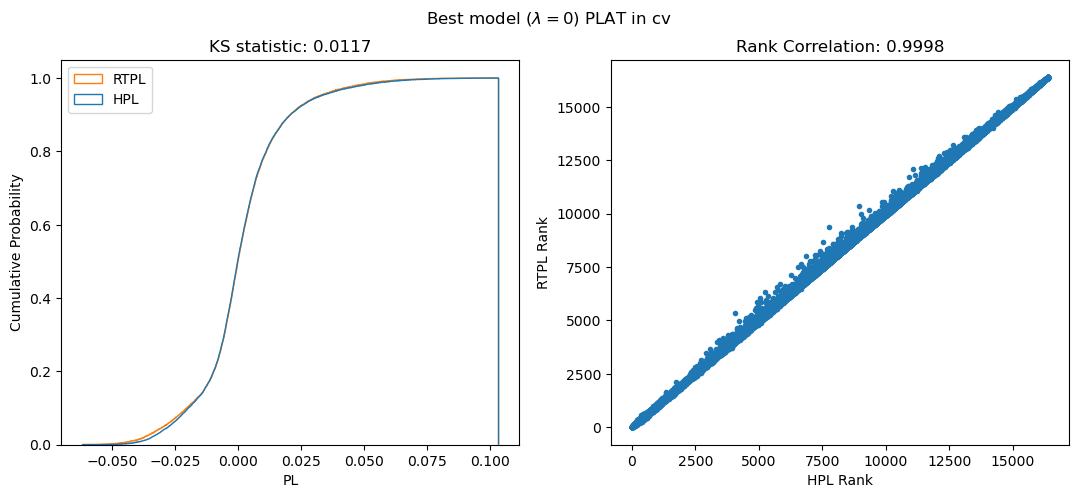

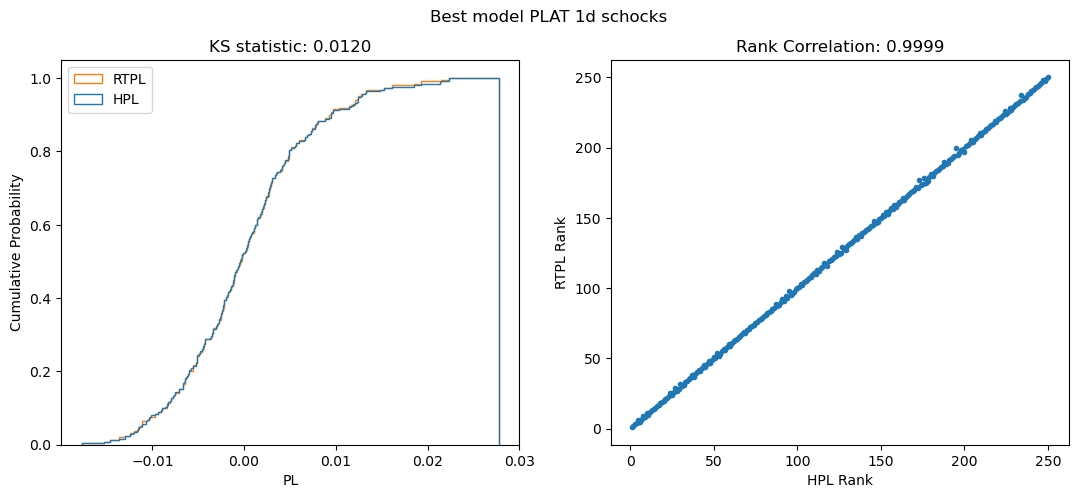

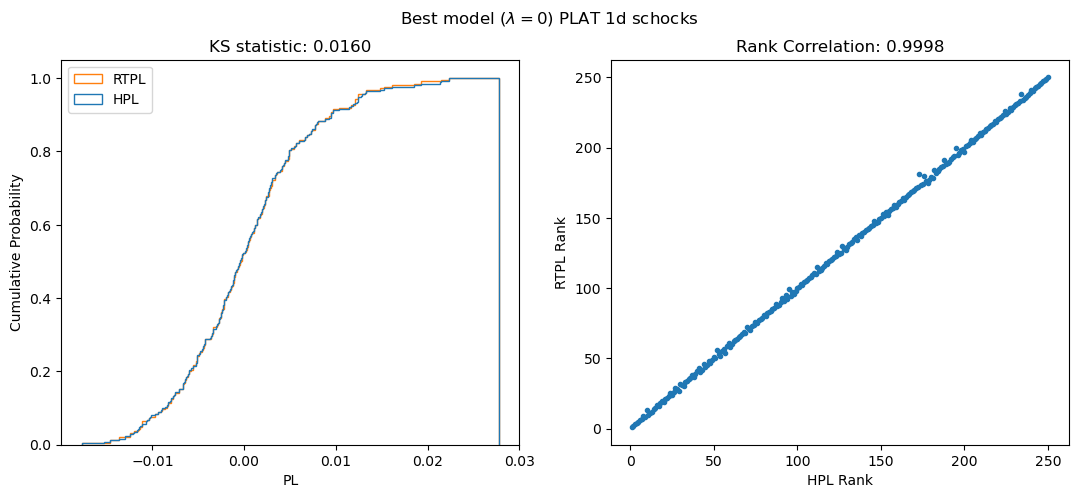

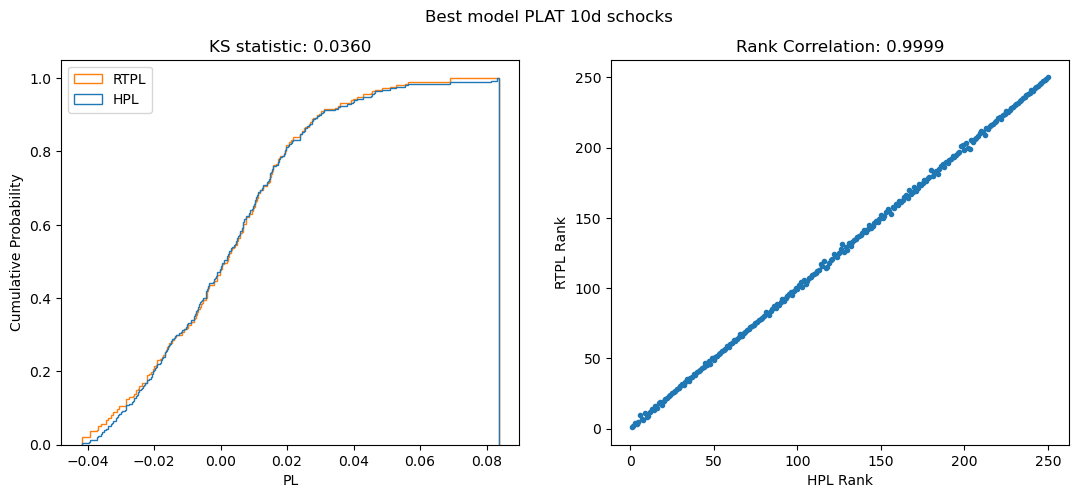

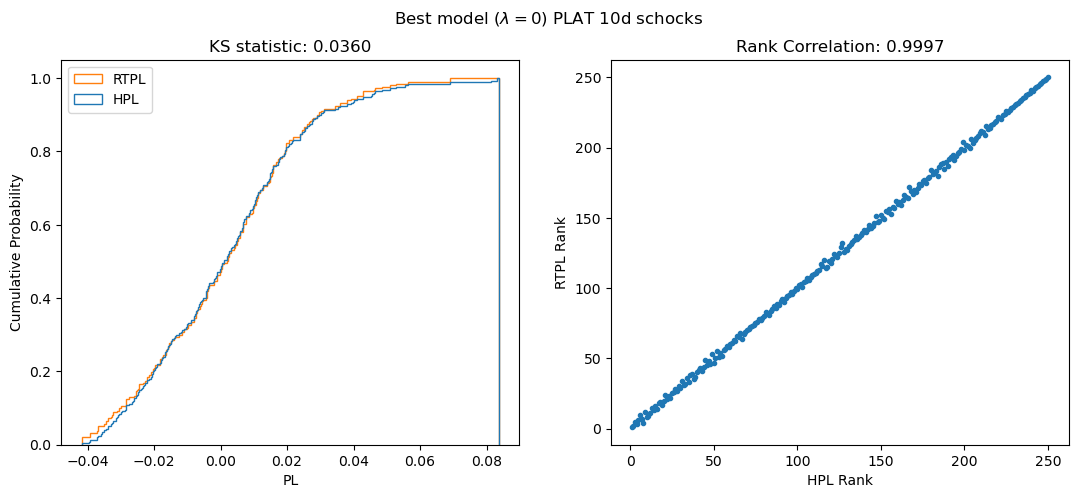

In [87]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:]

if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: mixed shocks'

file_name = 'VR_' + file_name

ModelHandlers.plot_model_results(metrics,best_model_metrics ,best_model_zero_alpha_metrics,alphas, cells_layer, num_hidden_layers, test_scenario_names,
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

### Compute metrics (hedge)

In [88]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    hedge_sim_data_PL_inc

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
#     adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS
else:
    model_adj_train = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = Enums.Base_Scenario_Adj_Option.NO


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + hedge_1d_PL_inc,
                     'model_adj': model_adj_test + hedge_1d_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + hedge_10d_PL_inc,
                     'model_adj': model_adj_test + hedge_10d_PL_inc}]

metrics, best_model_metrics,best_model_zero_alpha_metrics  = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers,
                    rf_levels_sim[train_range], payoff_sim[train_range], rf_levels_sim[test_range], payoff_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + hedge_sim_data_PL_inc[train_range],
                    model_adj_test + hedge_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)

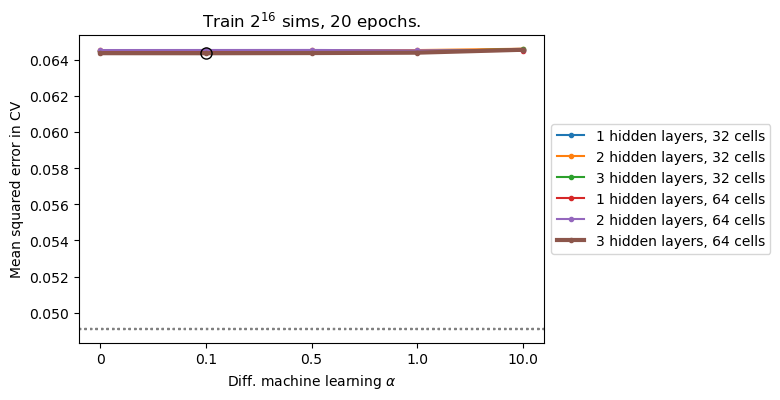

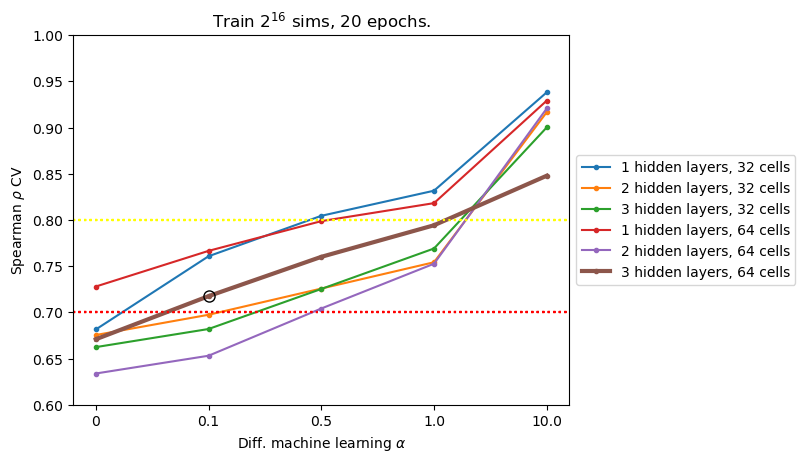

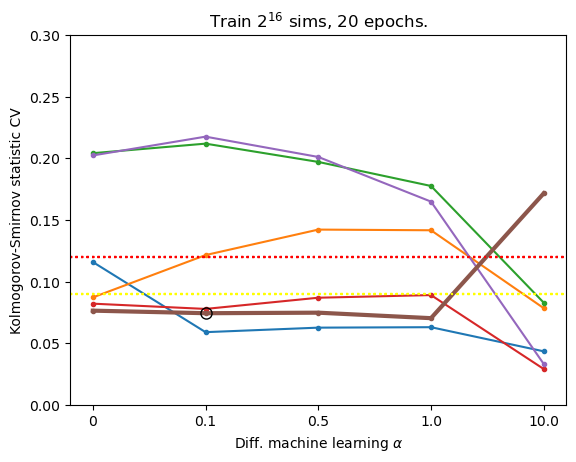

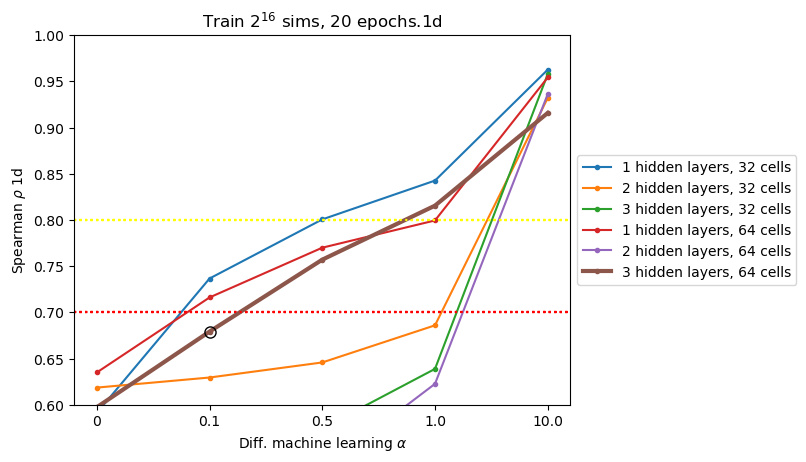

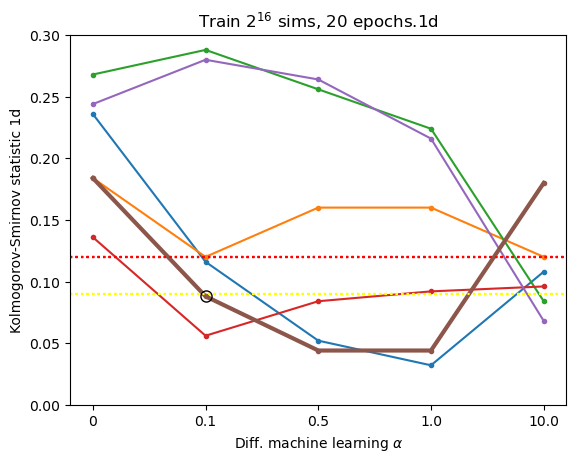

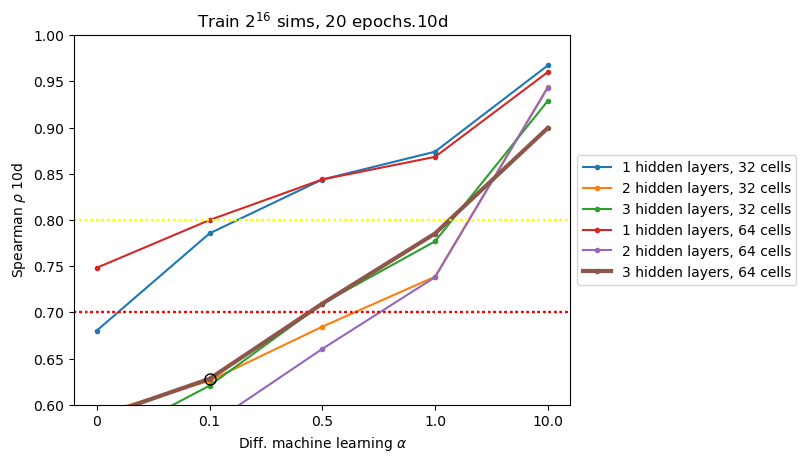

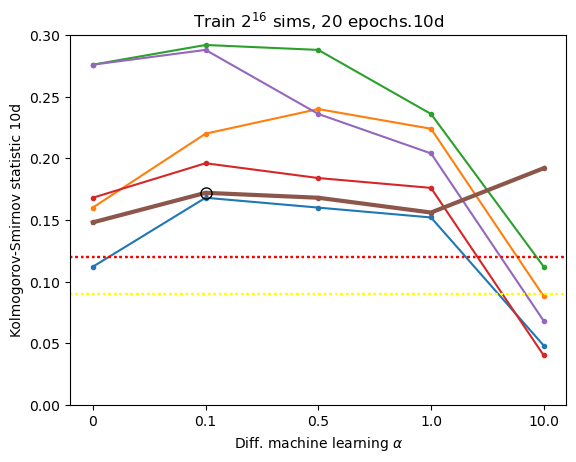

<Figure size 640x480 with 0 Axes>

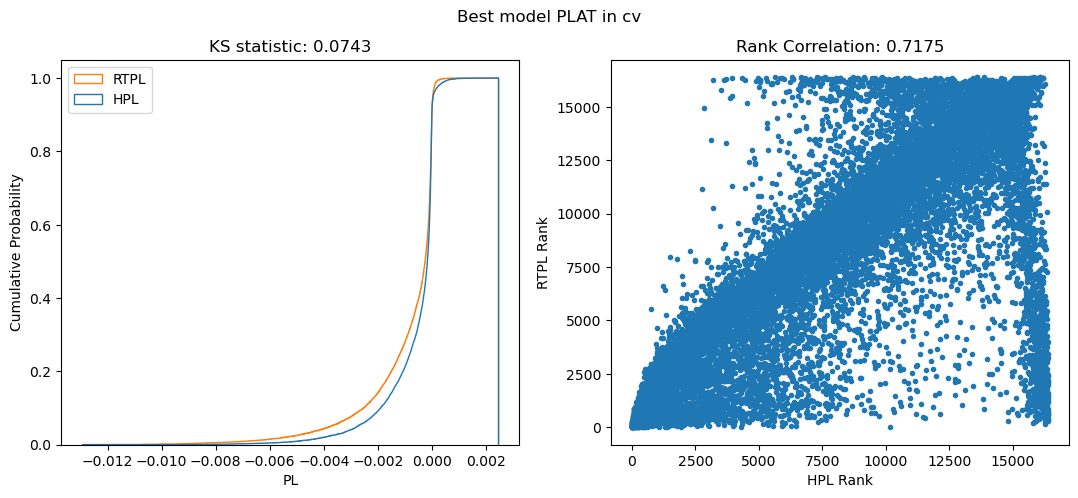

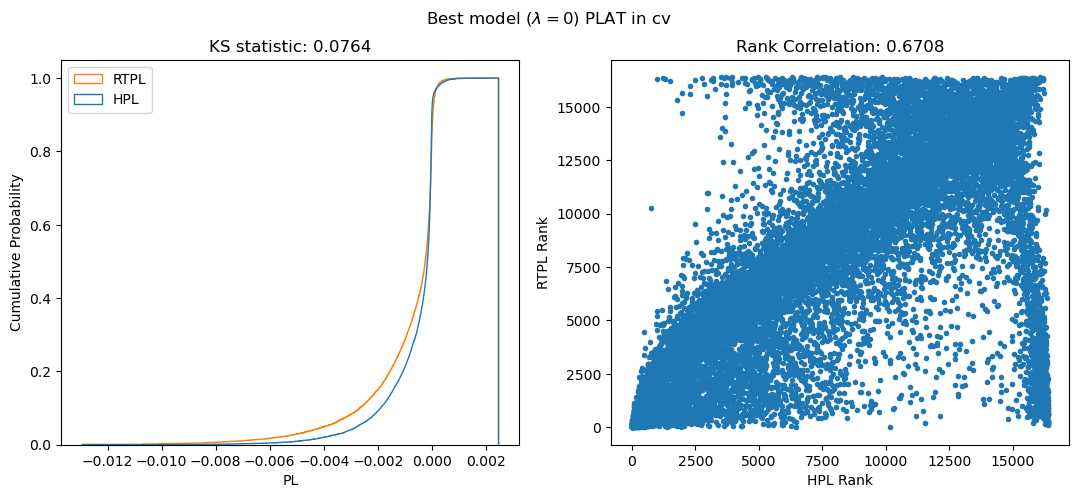

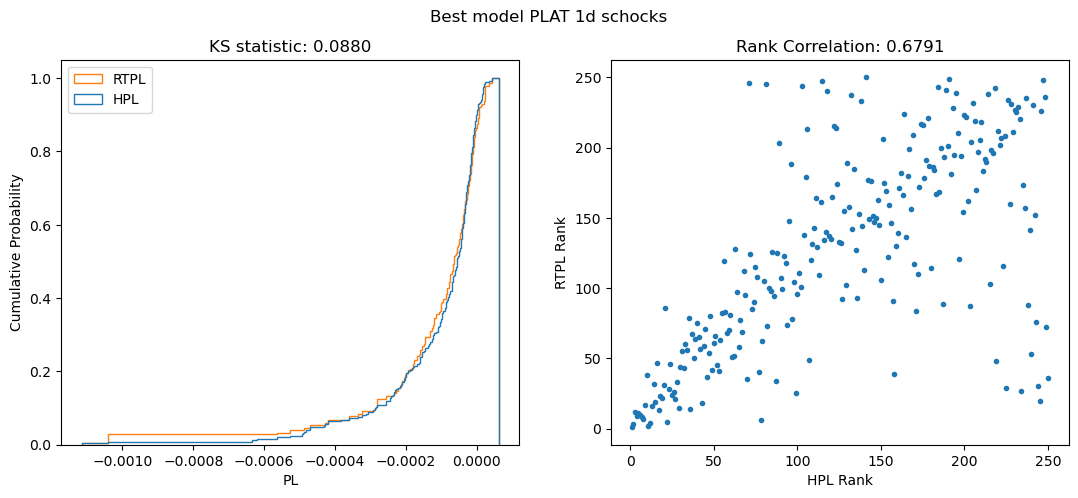

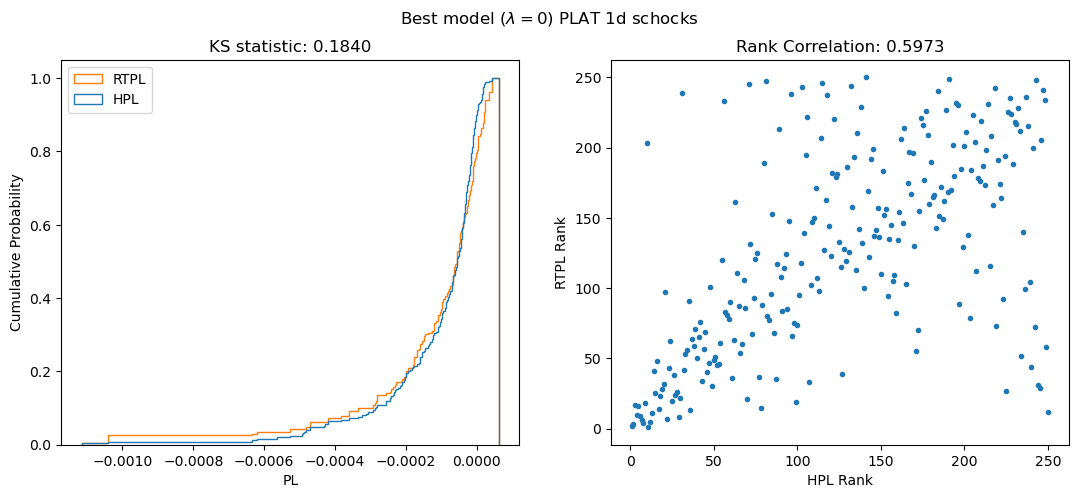

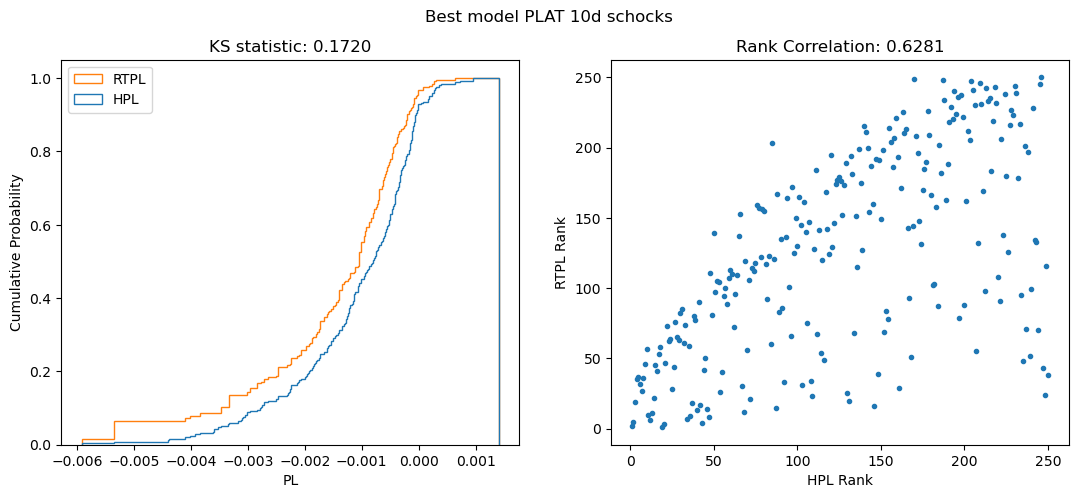

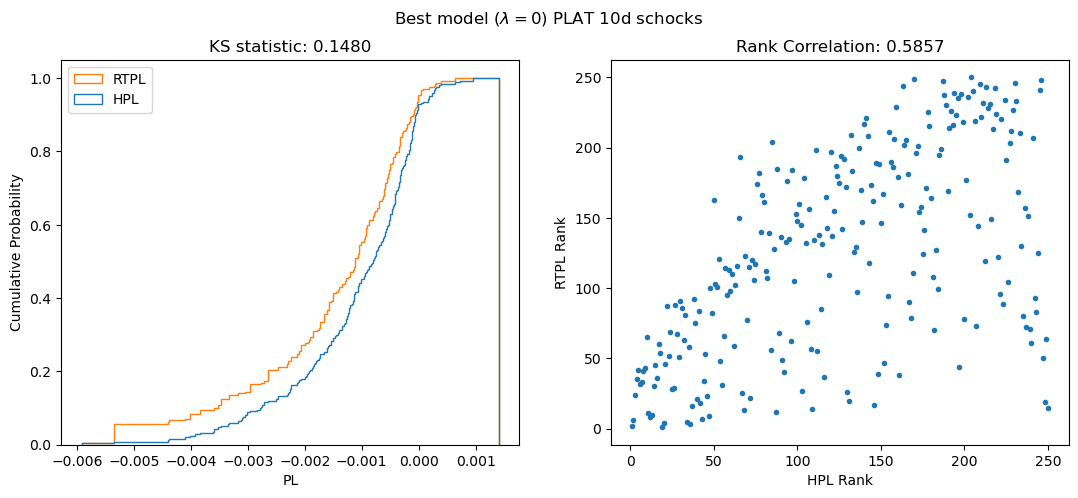

In [89]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:]

if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: mixed shocks'

file_name = 'VR_' + file_name

ModelHandlers.plot_model_results(metrics,best_model_metrics,best_model_zero_alpha_metrics ,alphas, cells_layer, num_hidden_layers, test_scenario_names,
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

In [134]:
tf.keras.utils.set_random_seed(9876)


base_scenario_data = {'scenario_levels': dict_1d_results['base_scenario'].reshape(1,-1),
                      'closed_form_value': closed_form_base,
                      'closed_form_sens': sens_base_scenario,
                      'hedge_NPV': hedge_base}

test_scenario_data = { 'scenario_name': '1d',
                        'scenario_levels': dict_1d_results['hist_scenario_levels'],
                        'closed_form_value': closed_form_hist_scenario_levels_1d,
                        'hedge_NPV': hedge_1d_NPV}

train_scenario_data = {'scenario_levels': dict_mixed_data_train_VR['sim_scenario_levels'][train_range],
                        'payoff': dict_mixed_data_train_VR['payoff'][train_range],
                        'pathwise_derivs': dict_mixed_data_train_VR['pathwise_derivs'][train_range]}

model_data =  {'input_dim': 6,
                'num_hidden_layers': 3,
                'num_cells_hidden_layers': 64,
                'hidden_layer_activation': 'softplus',
                'output_layer_activation': 'linear',
                'alpha': 0.0,
                'batch_size': 32,
                'num_epochs': 10,
                'verbose': 1}

plat_data = {'plat_analysis_option': Enums.Plat_Analysis_Option.VAR_REDUCTION,
            'num_batches_callback': 256}

plat_results_trad_dict_VR = ModelHandlers.PLAT_Analysis(base_scenario_data, test_scenario_data,
                            train_scenario_data, model_data, plat_data)

clear_output()

In [135]:
model_data =  {'input_dim': 6,
                'num_hidden_layers': 3,
                'num_cells_hidden_layers': 64,
                'hidden_layer_activation': 'softplus',
                'output_layer_activation': 'linear',
                'alpha': 1.0,
                'batch_size': 32,
                'num_epochs': 10,
                'verbose': 1}

plat_results_diff_learn_dict_VR = ModelHandlers.PLAT_Analysis(base_scenario_data, test_scenario_data,
                            train_scenario_data, model_data, plat_data)

clear_output()

In [136]:
# Miscellanea.plot_plat_training_plotly(
#                     [plat_results_trad_dict['plat_callback_Hedge_SENS'],
#                     plat_results_trad_dict['plat_callback_SENS'],
#                     plat_results_trad_dict_VR['plat_callback_Hedge_SENS'],
#                     plat_results_trad_dict_VR['plat_callback_SENS']],
#                     ['Hedged', 'Unhedged', 'Hedged VR', 'Unhedged  VR'],
#                     PATH_HTML + 'training_sens_VR.html', PATH_FIGS + 'training_sens_VR.pdf')

Miscellanea.plot_plat_training_plotly(
                    [
                    plat_results_trad_dict_VR['plat_callback_Hedge_SENS'],
                    plat_results_trad_dict_VR['plat_callback_SENS'],
                    plat_results_diff_learn_dict_VR['plat_callback_Hedge_SENS'],
                    plat_results_diff_learn_dict_VR['plat_callback_SENS']],
                    ['Hedged', 'Unhedged', 'Hedged Diff Learning', 'Unhedged  Diff Learning'],
                    PATH_HTML + 'training_sens_VR.html', PATH_FIGS + 'training_sens_VR.pdf')

In [52]:
Miscellanea.plot_plat_training_plotly(
                    [
                    plat_results_diff_learn_dict_VR['plat_callback_Hedge_SENS'],
                    plat_results_diff_learn_dict['plat_callback_Hedge_SENS'],
                    plat_results_trad_dict_VR['plat_callback_Hedge_SENS'],
                    plat_results_trad_dict['plat_callback_Hedge_SENS']],
                    ['Hedged VR. Diff', 'Hedged. Diff', 'Hedged VR.', 'Hedged.'],
                    PATH_HTML + 'training_sens_VR.html', PATH_FIGS + 'training_sens_VR.pdf')

In [ ]:
Miscellanea.plot_plat_charts(plat_results_trad_dict_VR['plat_callback_Hedge_SENS'].output_dict['y_true'][-1],
                             plat_results_trad_dict_VR['plat_callback_Hedge_SENS'].output_dict['y_pred'][-1]);

plt.savefig(PATH_FIGS + 'Plat_chart_Hedged_VR_Sens_trad.pdf')

In [ ]:
html_output = Miscellanea.animate_plat_evolution(plat_results_trad_dict_VR['plat_callback_Hedge_SENS'],
            "Variance reduction with control variable (NPV + sens). Hedged basket option. " + r"$\lambda=0.0$" + "   ",
                                                PATH_HTML + 'Sens_VR_Hedged_trad_animation.html')

HTML(html_output)

## Training models to covexity

In [ ]:
tf.keras.utils.set_random_seed(9876)


base_scenario_data = {'scenario_levels': dict_1d_results['base_scenario'].reshape(1,-1),
                      'closed_form_value': closed_form_base,
                      'closed_form_sens': sens_base_scenario,
                      'hedge_NPV': hedge_base}

test_scenario_data = { 'scenario_name': '1d',
                        'scenario_levels': dict_1d_results['hist_scenario_levels'],
                        'closed_form_value': closed_form_hist_scenario_levels_1d,
                        'hedge_NPV': hedge_1d_NPV}

train_scenario_data = {'scenario_levels': dict_mixed_data_train_VR['sim_scenario_levels'][train_range],
                        'payoff': dict_mixed_data_train_VR['payoff'][train_range],
                        'pathwise_derivs': dict_mixed_data_train_VR['pathwise_derivs'][train_range]}

model_data =  {'input_dim': 6,
                'num_hidden_layers': 2,
                'num_cells_hidden_layers': 32,
                'hidden_layer_activation': 'softplus',
                'output_layer_activation': 'linear',
                'alpha': 1.0,
                'batch_size': 32,
                'num_epochs': 20,
                'verbose': 1}

plat_data = {'plat_analysis_option': Enums.Plat_Analysis_Option.CONVEXITY,
            'num_batches_callback': 256}

plat_results_trad_dict_CONV = ModelHandlers.PLAT_Analysis(base_scenario_data, test_scenario_data,
                            train_scenario_data, model_data, plat_data)

clear_output()


In [ ]:
Miscellanea.plot_plat_training_plotly(
                    [plat_results_trad_dict_CONV['plat_callback_Hedge_SENS'],
                    plat_results_trad_dict_CONV['plat_callback_SENS'],
                    plat_results_trad_dict_VR['plat_callback_Hedge_SENS'],
                    plat_results_trad_dict_VR['plat_callback_SENS'],],
                    ['Hedged conv', 'Unhedged conv','Hedged sens', 'Unhedged sens'],
                    PATH_HTML + 'training_conv.html', PATH_FIGS + 'training_conv.pdf')

In [ ]:
html_output = Miscellanea.animate_plat_evolution(plat_results_trad_dict_CONV['plat_callback_Hedge_NPV'],
            "Variance reduction with control variable (NPV + sens). Hedged basket option. " + r"$\lambda=0.0$" + "   ",
                                                PATH_HTML + 'lalalal.html')

HTML(html_output)

### Computation of linear terms:

In [ ]:
linear_term_sim = np.matmul((rf_levels_sim - base_scenario), sens_base_scenario.reshape(-1,1)).flatten()

linear_term_1d = np.matmul((dict_1d_results['hist_scenario_levels'] - base_scenario), sens_base_scenario.reshape(-1,1)).flatten()

linear_term_10d = np.matmul((dict_10d_results['hist_scenario_levels'] - base_scenario), sens_base_scenario.reshape(-1,1)).flatten()



### Train models (linear)

In [ ]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [0]
num_hidden_layers = [0]
# cells_layer = [64]
# num_hidden_layers = [3]
# num_hidden_layers = [1]


PATH_MODELS = 'MODELS_CONVEXITY_VR/LINEAR/'


batch_size = num_sims_train
valid_data = None
epochs = 20


ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_mixed_data_train_VR['sim_scenario_levels'][train_range],
              dict_mixed_data_train_VR['payoff'][train_range]-linear_term_sim[train_range],
              dict_mixed_data_train_VR['pathwise_derivs'][train_range]-sens_base_scenario, epochs, batch_size, valid_data)

### Train models (non linear)

In [ ]:
train_range = np.arange(0,num_sims_train)
# train_range_reduced = np.arange(0,2**14)
test_range = np.arange(num_sims_train,num_sims_train + num_sims_test)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

PATH_MODELS = 'MODELS_CONVEXITY_VR/NON_LINEAR/'


batch_size = 32
valid_data = None
epochs = 20


ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,'softplus',
              dict_mixed_data_train_VR['sim_scenario_levels'][train_range],
              dict_mixed_data_train_VR['payoff'][train_range]-linear_term_sim[train_range],
              dict_mixed_data_train_VR['pathwise_derivs'][train_range]-sens_base_scenario, epochs, batch_size, valid_data)

In [ ]:
# PATH_MODELS = 'MODELS_VR/MODELS_1D/'
# PATH_MODELS = 'MODELS_VR/MODELS_10D/'
PATH_MODELS = 'MODELS_CONVEXITY_VR/LINEAR/'

alphas = [0.1, 0.5, 1.0, 10.0]
# cells_layer = [64]
# num_hidden_layers = [3]
cells_layer = [0]
num_hidden_layers = [0]

models_linear = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)

In [ ]:
# PATH_MODELS = 'MODELS_VR/MODELS_1D/'
# PATH_MODELS = 'MODELS_VR/MODELS_10D/'
PATH_MODELS = 'MODELS_CONVEXITY_VR/NON_LINEAR/'

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64]
num_hidden_layers = [1, 2, 3]

models_non_linear = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)

In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    basket_sim_data_PL_inc

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = "NPV"
#     adjust_model_with_base_scenario = "NPV_plus_sens"
else:
    model_adj_train = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = "No"


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + basket_1d_PL_inc,
                     'model_adj': model_adj_test + basket_1d_PL_inc + linear_term_1d}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + basket_10d_PL_inc,
                     'model_adj': model_adj_test + basket_10d_PL_inc + linear_term_10d}]

metrics, best_model_metrics,best_model_zero_alpha_metrics  = ModelHandlers.compute_model_metrics(models_non_linear, alphas, cells_layer, num_hidden_layers,
                    rf_levels_sim[train_range], payoff_sim[train_range] - linear_term_sim[train_range],
                    rf_levels_sim[test_range], payoff_sim[test_range] - linear_term_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + basket_sim_data_PL_inc[train_range] + linear_term_sim[train_range],
                    model_adj_test + basket_sim_data_PL_inc[test_range] + linear_term_sim[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)

In [ ]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:]

if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: mixed shocks'

file_name = 'VR_' + file_name

ModelHandlers.plot_model_results(metrics,best_model_metrics,best_model_zero_alpha_metrics ,alphas, cells_layer, num_hidden_layers, test_scenario_names,
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

In [ ]:
# PATH_MODELS = 'MODELS_VR/MODELS_1D/'
# PATH_MODELS = 'MODELS_VR/MODELS_10D/'
PATH_MODELS = 'MODELS_CONVEXITY_VR/LINEAR/'

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [0]
num_hidden_layers = [0]

models_linear = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)

In [ ]:
BASE_SCEN_CTRL_VAR = True


closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base + \
    basket_sim_data_PL_inc

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = "NPV"
#     adjust_model_with_base_scenario = "NPV_plus_sens"
else:
    model_adj_train = - 0
    model_adj_test = - 0
    adjust_model_with_base_scenario = "No"


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base + basket_1d_PL_inc,
                     'model_adj': model_adj_test + basket_1d_PL_inc + linear_term_1d}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': dict_10d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_10d - closed_form_base + basket_10d_PL_inc,
                     'model_adj': model_adj_test + basket_10d_PL_inc + linear_term_10d}]

metrics, best_model_metrics,best_model_zero_alpha_metrics  = ModelHandlers.compute_model_metrics(models_linear, alphas, cells_layer, num_hidden_layers,
                    rf_levels_sim[train_range], payoff_sim[train_range] - linear_term_sim[train_range],
                    rf_levels_sim[test_range], payoff_sim[test_range] - linear_term_sim[test_range],
                    closed_formula_plus_adj[train_range], closed_formula_plus_adj[test_range],
                    model_adj_train + basket_sim_data_PL_inc[train_range] + linear_term_sim[train_range],
                    model_adj_test + basket_sim_data_PL_inc[test_range] + linear_term_sim[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)

In [ ]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:]

if PATH_MODELS == 'MODELS_VR/MODELS_1D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 1d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_10D/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: 10d shocks'
elif PATH_MODELS == 'MODELS_VR/MODELS_MIXED/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Data: mixed shocks'

file_name = 'VR_' + file_name

ModelHandlers.plot_model_results(metrics,best_model_metrics,best_model_zero_alpha_metrics ,alphas, cells_layer, num_hidden_layers, test_scenario_names,
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

# Testeo convexidad

In [ ]:
from scipy.stats import spearmanr
from scipy.stats import ks_2samp
from scipy.stats import rankdata



def plot_plat_charts(hpl, rtpl, ax,fig_tittle = ''):
    """
    Plots comparison charts for given HPL
    and RTPL data.
    Both cum probability and rank correlation plots.

    Parameters:
    - hpl: List or array of HPL data.
    - rtpl: List or array of RTPL data.
    - fig_tittle: Tittle of the whole figure


    Returns:
    - fig: A Matplotlib figure containing two subplots.
    """

    # First subplot: Cumulative histogram for HPL and RTPL
#     ax[0].hist([hpl, rtpl], density=True, histtype="step", cumulative=True, bins=np.unique(np.sort(np.concatenate([hpl, rtpl]))),
#                label=['HPL', 'RTPL'])
    ax[0].hist([hpl, rtpl], density=True, histtype="step", cumulative=True, bins=np.unique(np.sort(hpl)),
               label=['HPL', 'RTPL'])
    ax[0].legend(loc='upper left')
    ax[0].set_xlabel('PL')
    ax[0].set_ylabel('Cumulative Probability')

    ax[0].set_title('KS statistic: ' + format(ks_2samp(hpl, rtpl)[0], '0.4f'))

    # Second subplot: Scatter plot of ranked HPL versus RTPL
    ax[1].plot(rankdata(hpl), rankdata(rtpl), '.')
    ax[1].set_xlabel('HPL Rank')
    ax[1].set_ylabel('RTPL Rank')

    ax[1].set_title('Rank Correlation:' +  format(spearmanr(hpl, rtpl)[0], '0.4f'))
    # Set figure size
    fig.set_size_inches(13, 5)

    fig.suptitle(fig_tittle)
    # Return the figure object
    return fig




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np




# Create a figure for the animation
fig, ax = plt.subplots(1,2)

# Animation update function
def update(frame):
    # Clear the current axes
    ax[0].clear()
    ax[1].clear()


    # Select the data for the current frame
    hpl = plat_callback_NPV.output_dict['y_true'][frame]
    rtpl = plat_callback_NPV.output_dict['y_pred'][frame]

    # Call your plot function
    Miscellanea.plot_plat_charts(hpl, rtpl,fig_ax_list = [fig, ax] ,fig_tittle=f"Frame {frame}")

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(plat_callback_NPV.output_dict['y_true']), repeat=True)

# plt.show()


In [ ]:
def animate_plat_evolution(plat_results):

    # Create a figure for the animation
    fig, ax = plt.subplots(1,2)

    # Animation update function
    def update(frame):
        # Clear the current axes
        ax[0].clear()
        ax[1].clear()


        # Select the data for the current frame
        hpl = plat_results.output_dict['y_true'][frame]
        rtpl = plat_results.output_dict['y_pred'][frame]

        # Call your plot function
        Miscellanea.plot_plat_charts(hpl, rtpl,fig_ax_list = [fig, ax] ,fig_tittle=f"Frame {frame}")

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(plat_results.output_dict['y_true']), repeat=True)

    return(ani)


In [ ]:
ani = animate_plat_evolution(plat_callback_NPV)

In [ ]:
html_output = ani.to_jshtml()

HTML(html_output)

In [ ]:
with open(PATH_HTML + "animation_test.html", "w") as file:
    file.write(html_output)

In [ ]:
closed_formula_plus_adj = closed_form_sim_scenario_levels - closed_form_base


base_scenario_data = {'scenario_name': 'base', 'scenario': dict_1d_results['base_scenario'].reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base_scenario}

test_scenario_data = {'scenario_name': '1d', 'scenario': dict_1d_results['hist_scenario_levels'],
                    'closed_formula_plus_adj': closed_form_hist_scenario_levels_1d - closed_form_base,
                     'model_adj': 0}

model = Deep_learning_models.build_diff_learning_model(6, 3, 64, 'softplus', 'linear', 0.0)

# test_scenario_data['model_adj'] = - closed_form_base

plat_NO =  Deep_learning_models.Plat_Callback(base_scenario_data, test_scenario_data, model,
        Enums.Base_Scenario_Adj_Option.NO, 32)

test_scenario_data['model_adj'] = 0

plat_NPV =  Deep_learning_models.Plat_Callback(base_scenario_data, test_scenario_data, model,
        Enums.Base_Scenario_Adj_Option.NPV, 32)

plat_SENS =  Deep_learning_models.Plat_Callback(base_scenario_data, test_scenario_data, model,
        Enums.Base_Scenario_Adj_Option.NPV_PLUS_SENS, 32)



hist = model.fit(dict_mixed_data_train_VR['sim_scenario_levels'][train_range],
              dict_mixed_data_train_VR['payoff'][train_range],
              dict_mixed_data_train_VR['pathwise_derivs'][train_range], 32, 5, None,
                 [plat_NO, plat_NPV, plat_SENS], verbose = 1)

clear_output()

In [58]:
tf.keras.utils.set_random_seed(9876)


base_scenario_data = {'scenario_levels': dict_1d_results['base_scenario'].reshape(1,-1),
                      'closed_form_value': closed_form_base,
                      'closed_form_sens': sens_base_scenario,
                      'hedge_NPV': hedge_base}

test_scenario_data = { 'scenario_name': '1d',
                        'scenario_levels': dict_1d_results['hist_scenario_levels'],
                        'closed_form_value': closed_form_hist_scenario_levels_1d,
                        'hedge_NPV': hedge_1d_NPV}

train_scenario_data = {'scenario_levels': dict_mixed_data_train_VR['sim_scenario_levels'][train_range],
                        'payoff': dict_mixed_data_train_VR['payoff'][train_range],
                        'pathwise_derivs': dict_mixed_data_train_VR['pathwise_derivs'][train_range]}

model_data =  {'input_dim': 6,
                'num_hidden_layers': 3,
                'num_cells_hidden_layers': 64,
                'hidden_layer_activation': 'softplus',
                'output_layer_activation': 'linear',
                'alpha': 1.0,
                'batch_size': 32,
                'num_epochs': 10,
                'verbose': 1}

plat_data = {'plat_analysis_option': Enums.Plat_Analysis_Option.CONVEXITY ,
            'num_batches_callback': 256}

plat_results_trad_dict_VR = ModelHandlers.PLAT_Analysis(base_scenario_data, test_scenario_data,
                            train_scenario_data, model_data, plat_data)

clear_output()

In [62]:
plat_results_trad_dict_VR

{'plat_callback_NO': <Deep_learning_models.Plat_Callback at 0x22c735dc9c8>,
 'plat_callback_NPV': <Deep_learning_models.Plat_Callback at 0x22c735dc788>,
 'plat_callback_SENS': <Deep_learning_models.Plat_Callback at 0x22c735dcdc8>,
 'plat_callback_Hedge_NO': <Deep_learning_models.Plat_Callback at 0x22c735dc508>,
 'plat_callback_Hedge_NPV': <Deep_learning_models.Plat_Callback at 0x22c735dc308>,
 'plat_callback_Hedge_SENS': <Deep_learning_models.Plat_Callback at 0x22c47a39148>}

In [64]:
Miscellanea.plot_plat_training_plotly(
                    [
                    plat_results_trad_dict_VR['plat_callback_Hedge_NPV']],
                    ['Hedged VR. Diff'],
                    PATH_HTML + 'training_sens_VR.html', PATH_FIGS + 'training_sens_VR.pdf')

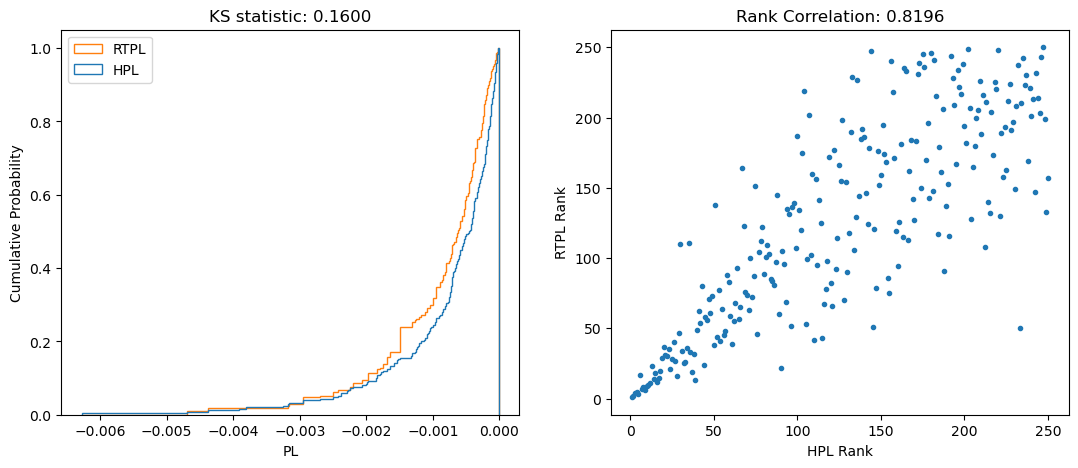

In [65]:
Miscellanea.plot_plat_charts(plat_results_trad_dict_VR['plat_callback_Hedge_NPV'].output_dict['y_true'][-1],
                             plat_results_trad_dict_VR['plat_callback_Hedge_NPV'].output_dict['y_pred'][-1]);

## As time goes by

In [ ]:
# Data simulation dictionaries:
gaussian_model_dict = {
    'n_examples': 250,
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': None,
    'vol_indexes': [1, 3, 5],
    'vols': None,
    'correlations': None,
    'rfr': 0.01,
    'divs': 0.0,
    'num_escen_correl_matrix': 250,
    'base_scenario': None
}

simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.NO
}


contract_data_dict = {
    'ttm': None,
    'generic_payoff': lambda indiv_strikes_value: \
                        lambda spot_t: \
                        (Scenario_Simulation.basket_option(spots_t= spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.0,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES)- \
                        Scenario_Simulation.basket_option(
                            spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.1,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES))/0.1,
    'payoff': None,
    'generic_closed_form_formula': lambda indiv_strikes_value, maturity: \
                            lambda spot_t, vol_t, rfr, divs, correl: \
                            (Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.0, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True) -
                            Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.1, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True))/0.1,
    'closed_form_formula': None,
    'indiv_strikes': None
}


training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 0.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/NAIVE_LAMBDA_0/"
}

risk_management_dict = {
    'maturity_in_months_at_reset_dates': 36,
    'end_date': hist_data.index[-1],
    'initial_date': hist_data.index[gaussian_model_dict['n_examples'] + 1]
}


In [ ]:
# Data simulation dictionaries:
gaussian_model_dict = {
    'n_examples': 250,
    'n_components': 6,
    'gaussian_model_seed': 1234
}

base_scenario_dict = {
    'spot_indexes': [0, 2, 4],
    'spots': None,
    'vol_indexes': [1, 3, 5],
    'vols': None,
    'correlations': None,
    'rfr': 0.01,
    'divs': 0.0,
    'num_escen_correl_matrix': 250,
    'base_scenario': None
}

simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.NO
}


contract_data_dict = {
    'ttm': None,
    'generic_payoff': lambda indiv_strikes_value: \
                        lambda spot_t: \
                        Scenario_Simulation.basket_option(spots_t= spot_t,
                            indiv_strikes=indiv_strikes_value,
                            option_strike=1.0,
                            tf_option=Enums.Include_Tensorflow_Calcs_option.YES),
    'payoff': None,
    'generic_closed_form_formula': lambda indiv_strikes_value, maturity: \
                            lambda spot_t, vol_t, rfr, divs, correl: \
                            Option_formulas.BasketOptionVectorized(num_assets = 3,
                                initial_prices = spot_t, strike_prices = indiv_strikes_value,
                                gross_return_strike = 1.0, repo_rates = rfr*np.ones(3),
                                discount_rate = rfr, dividends = divs*np.ones(3),
                                volatilities = vol_t, correlations = correl,
                                time_to_maturity = maturity, IsCall = True),
    'closed_form_formula': None,
    'indiv_strikes': None
}


training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 0.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/NAIVE_LAMBDA_0/"
}

risk_management_dict = {
    'maturity_in_months_at_reset_dates': 36,
    'end_date': hist_data.index[-1],
    'initial_date': hist_data.index[gaussian_model_dict['n_examples'] + 1]
}


In [ ]:
mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data)

In [ ]:
mmm.train_models_for_all_dates()

In [ ]:
mmm.continue_training_models()

In [ ]:
mmm.init_and_maturity_dates

In [ ]:
my_date = pd.Timestamp('2019-12-06')

mmm.update_base_scenario(my_date)
mmm.update_payoff(pd.Timestamp(my_date))
mmm.update_hedge(pd.Timestamp(my_date))

shocks = mmm.compute_training_data(my_date)['sim_scenario_levels']

exot_pl = (mmm.contract_data_dict['closed_form_formula'](shocks) - \
  mmm.contract_data_dict['closed_form_formula'](mmm.base_scenario_dict['base_scenario'])).numpy()

hedge_pl = (mmm.hedge.value_basket(shocks) - \
  mmm.hedge.value_basket(mmm.base_scenario_dict['base_scenario']))

pl = exot_pl + hedge_pl

plt.plot(exot_pl, hedge_pl, '.')

# plt.hist([exot_pl, pl], bins = 100);

In [ ]:
col_index = 4
num = 100
shocks = np.ones((num,6))
shocks[:,col_index] = np.linspace(0.8,1.2,num)

shocked_values = mmm.base_scenario_dict['base_scenario'] * shocks

exot = mmm.contract_data_dict['closed_form_formula'](shocked_values) - \
            mmm.contract_data_dict['closed_form_formula'](mmm.base_scenario_dict['base_scenario']) 

hedge = mmm.hedge.value_basket(shocked_values) - mmm.hedge.value_basket(mmm.base_scenario_dict['base_scenario'])

plt.plot(shocked_values[:,col_index], exot)
plt.plot(shocked_values[:,col_index], hedge)


In [ ]:
Miscellanea.plot_schocks(6,[shocks,mmm.base_scenario_dict['base_scenario']],['a','a','a','a','a','a'],100)

In [ ]:
mmm.base_scenario_dict

In [ ]:
mmm.hedge.weights

In [ ]:
my_date = pd.Timestamp('2013-02-15')
mmm.update_base_scenario(my_date)
mmm.update_base_scenario(my_date)
mmm.update_base_scenario(my_date)

In [ ]:
mmm.base_scenario_dict

In [ ]:
mmm.model = Deep_learning_models.Diff_learning_scaler.open('MODELS/MODELS_MANAGEMENT/NAIVE_LAMBDA_0_0/2018-12-04/')

In [ ]:
a = np.arange(0,9).reshape(3,3)

df = pd.DataFrame(data = a, columns = ['a', 'b', 'c'])

display(df)

x = df.iloc[2].values

x /= 3.0

display(df)


In [ ]:
mmm.model = Deep_learning_models.Diff_learning_scaler.open('MODELS/MODELS_MANAGEMENT/NAIVE_LAMBDA_0_0/2018-12-04/')

mmm.train_model(pd.Timestamp('2018-12-07'))

In [ ]:
kkk = mmm.compute_training_data(pd.Timestamp('2018-12-06'))


In [ ]:
plt.plot(kkk['payoff'])

In [ ]:
mmm.run_plat_analysis()

In [ ]:
plt.plot(mmm.dates[0:len(mmm.hpl)], mmm.hpl)
plt.plot(mmm.dates[0:len(mmm.hpl)], mmm.rtpl, alpha = 0.5)
plt.plot(mmm.init_and_maturity_dates,np.zeros_like(mmm.init_and_maturity_dates),'o')


In [ ]:
plt.plot(mmm.hpl, mmm.rtpl,'.')

In [ ]:
xxx = pd.DataFrame()

xxx['dates'] = mmm.dates[0:-1]
xxx['hpl'] = mmm.hpl
xxx['rtpl'] = mmm.rtpl



In [ ]:
xxx.to_excel('lalala.xlsx')

In [ ]:
mmm.init_and_maturity_dates

In [ ]:
mmm.base_scenario_dict

In [ ]:
machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 1.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/NAIVE_LAMBDA_1_0/"
}

mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data)
# mmm.train_models_for_all_dates()

In [ ]:
simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.YES
}



training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 0.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/VR_0_0/"
}

mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data)
mmm.train_models_for_all_dates()


In [ ]:
simulation_dict = {
    'shocks_generation_option': Enums.MktRisk_Scenarios_Generation_Option.EXPONENTIAL,
    'tf_generation_option': Enums.Include_Tensorflow_Calcs_option.YES,
    'simulation_seed': 5678,
    'Simulate_Var_Red_Payoff': Enums.Simulate_Var_Red_Payoff.YES
}



training_data_generation_dict = {
        'gaussian_model_dict' : gaussian_model_dict,
        'base_scenario_dict': base_scenario_dict,
        'simulation_dict': simulation_dict,
        'contract_data_dict': contract_data_dict
    }

machine_learning_models_dict = {
    'nb_hidden_layers': 3,
    'nd_cells_hidden_layer': 64,
    'hidden_layer_activation': 'softplus',
    'output_layer_activation': 'linear',
    'batch_size': 32,
    'num_epochs_payoff_reset': 20,
    'num_epochs_daily_calc': 1,
    'num_training_examples_payoff_reset': 2**16,
    'num_training_examples_daily_calc': 2**14,
    'alpha' : 1.0,
    'verbose': 1,
    'MODELS_PATH': "MODELS/MODELS_MANAGEMENT/VR_1_0/"
}

mmm = ModelHandlers.plat_orquestrator(training_data_generation_dict, machine_learning_models_dict, risk_management_dict, hist_data)
# mmm.train_models_for_all_dates()

In [ ]:
mmm.continue_training_models()

In [ ]:
mmm.train_model(pd.Timestamp("2013-04-22"))


In [ ]:
mmm.compute_indiv_strikes(pd.Timestamp("2013-04-22"))

In [ ]:
pd.Timestamp('2017-12-07') in mmm.init_and_maturity_dates

In [ ]:
mmm.update_payoff(pd.Timestamp("2013-04-22"))
mmm.update_payoff(pd.Timestamp("2013-06-07"))

In [ ]:
x = np.repeat(a=np.linspace(0.8,1.2,100).reshape(-1,1), axis = 1, repeats = 3)*np.array([[19.045,183.3437,42.56]])

plt.plot(np.linspace(0.8,1.2,100),mmm.contract_data_dict['payoff'](x),'.')


In [ ]:
plt.plot(np.linspace(0.8,1.2,100),
         mmm.contract_data_dict['closed_form_formula'](spot_t = x,
          vol_t = mmm.base_scenario_dict['vols']*np.ones_like(x),
          rfr = mmm.base_scenario_dict['rfr'],
          divs = mmm.base_scenario_dict['divs'],
          correl = mmm.base_scenario_dict['correlations']),'.')


In [ ]:

xxx = mmm.compute_training_data(pd.Timestamp("2013-04-22"))
yyy = mmm.compute_training_data(pd.Timestamp("2013-04-23"))

In [ ]:
plt.hist([xxx['payoff'],yyy['payoff']], bins = 100)

In [ ]:
Miscellanea.plot_schocks(number_risk_factors=6, list_of_shocks= [xxx['sim_scenario_levels'],yyy['sim_scenario_levels']],
        risk_factor_names = ['lalala','lelele','lilili', 'lololo', 'lala', 'puf'], bins = 100)

In [ ]:
mmm.model.save('lalala')